<a href="https://colab.research.google.com/github/yeonkkk/AIFFEL-Project/blob/main/Exploration14/project/%5BE_14%5DARIMA_Stock_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# E-14. Stock Prediction

In [75]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


-----
# STEP 1: 시계열 데이터 준비

- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume

- 날짜별 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume) 저장

-  종가(Close)만 사용

In [274]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = '/content/drive/MyDrive/AIffel/ex14/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)

In [275]:
ts = df['Close']
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2020-11-16    66300.0
2020-11-17    65700.0
2020-11-18    64800.0
2020-11-19    64600.0
2020-11-20    64700.0
Name: Close, dtype: float64

-----

# STEP 2: 데이터 전처리

- 결측치 확인

- 로그 변환

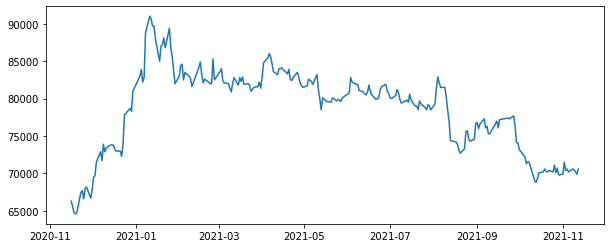

In [276]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 4

# 시계열(time series) 데이터를 차트로 그려 봅시다. 
# 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

In [277]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

Series([], Name: Close, dtype: float64)


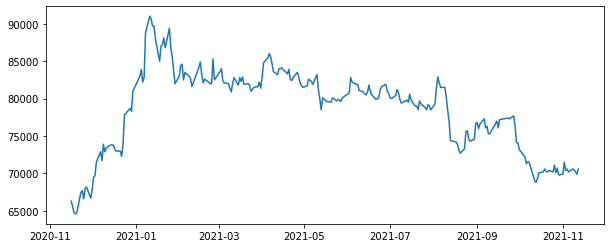

In [278]:
# 결측치가 있다면 이를 보간 
ts=ts.interpolate(method='time')

print(ts[ts.isna()])
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(ts)

In [279]:
# 로그 변환 시도 
ts_log = np.log(ts)

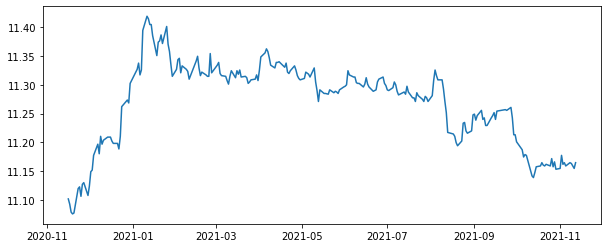

In [280]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(ts_log)

-----

# STEP 3: 시계열 안정성 분석

- 정성적 그래프 분석

- 정량적 Augmented Dicky-Fuller Test

- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

- 20일(1개월), 60일(3개월), 120일(6개월) 주기로 그래프를 확인해본다.

- 초기 p-value는 약 0.26이며, 좀 더 자세히 분석해 보았다.

- Residual 안정성을 보면 p-value가 거의 0에 가까운 값인 것을 확인할 수 있다.

In [281]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

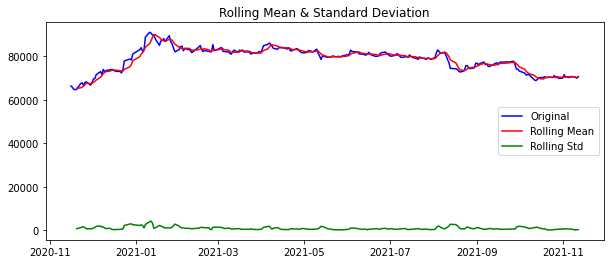

In [282]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_rolling_statistics(ts, window = 5)

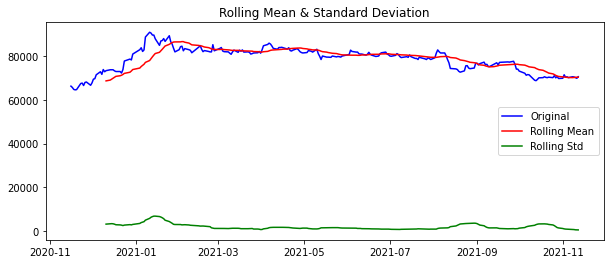

In [283]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_rolling_statistics(ts, window = 20)

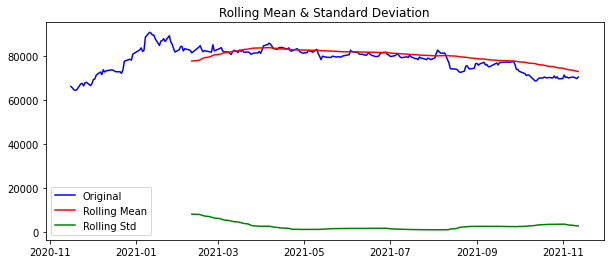

In [284]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_rolling_statistics(ts, window = 60)

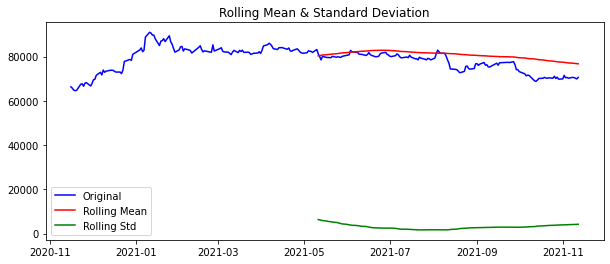

In [285]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_rolling_statistics(ts, window = 120)

In [286]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [287]:
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -2.043162
p-value                          0.267975
#Lags Used                       0.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


## (1) 로그 함수 변환

In [288]:
ts_log = np.log(ts)

In [289]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -2.078738
p-value                          0.253150
#Lags Used                       0.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


## (2) Moving average 제거 - 추세(Trend) 상쇄하기

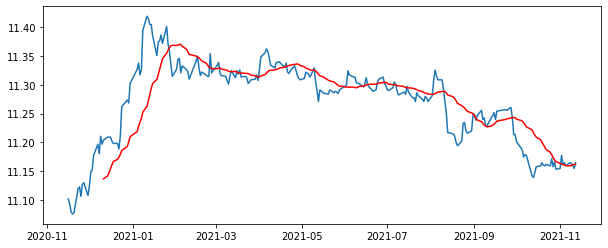

In [290]:
moving_avg20= ts_log.rolling(window=20).mean()  # moving average구하기 
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(ts_log)
plt.plot(moving_avg20, color='red')

In [291]:
ts_log_moving_avg20 = ts_log - moving_avg20 # 변화량 제거
ts_log_moving_avg20.dropna(inplace=True) # 결측치 제거
ts_log_moving_avg20.head(15)

Date
2020-12-11    0.067037
2020-12-14    0.067113
2020-12-15    0.061300
2020-12-16    0.054798
2020-12-17    0.041682
2020-12-18    0.031546
2020-12-21    0.027630
2020-12-22    0.014707
2020-12-23    0.031396
2020-12-24    0.076093
2020-12-28    0.080434
2020-12-29    0.067322
2020-12-30    0.092329
2021-01-04    0.107845
2021-01-05    0.109358
Name: Close, dtype: float64

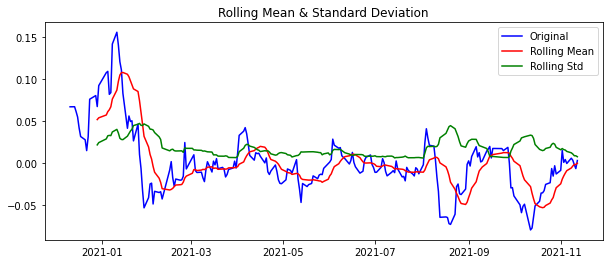

In [292]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_rolling_statistics(ts_log_moving_avg20)

In [293]:
augmented_dickey_fuller_test(ts_log_moving_avg20)

Results of Dickey-Fuller Test:
Test Statistic                  -3.546187
p-value                          0.006877
#Lags Used                      12.000000
Number of Observations Used    214.000000
Critical Value (1%)             -3.461282
Critical Value (5%)             -2.875143
Critical Value (10%)            -2.574020
dtype: float64


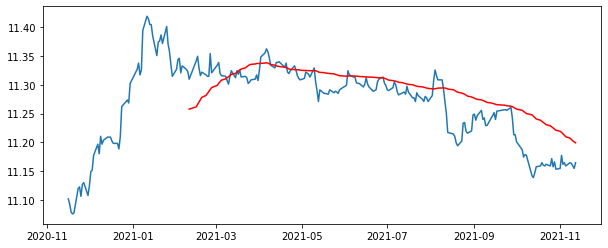

In [294]:
moving_avg60= ts_log.rolling(window=60).mean()  # moving average구하기 
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(ts_log)
plt.plot(moving_avg60, color='red')

In [295]:
ts_log_moving_avg60 = ts_log - moving_avg60 # 변화량 제거
ts_log_moving_avg60.dropna(inplace=True) # 결측치 제거
ts_log_moving_avg60.head(15)

Date
2021-02-10    0.052016
2021-02-15    0.079398
2021-02-16    0.083405
2021-02-17    0.059012
2021-02-18    0.041708
2021-02-19    0.043708
2021-02-22    0.035570
2021-02-23    0.029940
2021-02-24    0.026473
2021-02-25    0.062151
2021-02-26    0.025602
2021-03-02    0.035083
2021-03-03    0.036286
2021-03-04    0.014217
2021-03-05    0.007840
Name: Close, dtype: float64

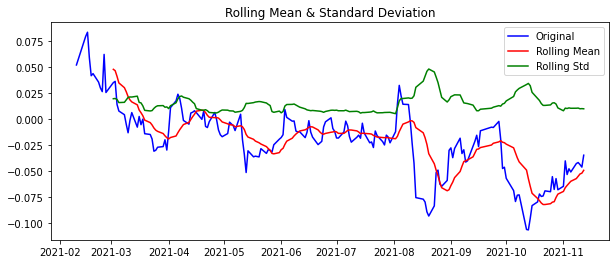

In [296]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_rolling_statistics(ts_log_moving_avg60)

In [297]:
augmented_dickey_fuller_test(ts_log_moving_avg60)

Results of Dickey-Fuller Test:
Test Statistic                  -3.506713
p-value                          0.007816
#Lags Used                       1.000000
Number of Observations Used    185.000000
Critical Value (1%)             -3.466201
Critical Value (5%)             -2.877293
Critical Value (10%)            -2.575168
dtype: float64


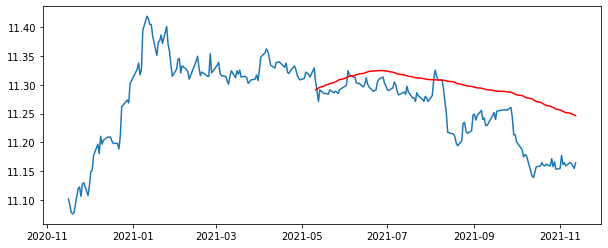

In [298]:
moving_avg120= ts_log.rolling(window=120).mean()  # moving average구하기 
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(ts_log)
plt.plot(moving_avg120, color='red')

In [299]:
ts_log_moving_avg120 = ts_log - moving_avg120 # 변화량 제거
ts_log_moving_avg120.dropna(inplace=True) # 결측치 제거
ts_log_moving_avg120.head(15)

Date
2021-05-11    0.013808
2021-05-12   -0.002646
2021-05-13   -0.023057
2021-05-14   -0.004646
2021-05-17   -0.012648
2021-05-18   -0.014375
2021-05-20   -0.016996
2021-05-21   -0.010878
2021-05-24   -0.017381
2021-05-25   -0.016219
2021-05-26   -0.018780
2021-05-27   -0.022763
2021-05-28   -0.017890
2021-05-31   -0.014134
2021-06-01   -0.014103
Name: Close, dtype: float64

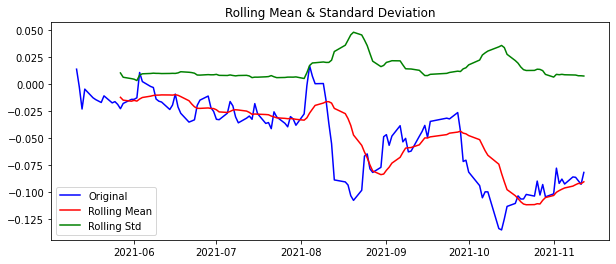

In [300]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_rolling_statistics(ts_log_moving_avg120)

In [301]:
augmented_dickey_fuller_test(ts_log_moving_avg120)

Results of Dickey-Fuller Test:
Test Statistic                  -2.009500
p-value                          0.282423
#Lags Used                       1.000000
Number of Observations Used    125.000000
Critical Value (1%)             -3.483779
Critical Value (5%)             -2.884954
Critical Value (10%)            -2.579257
dtype: float64


## (3) 차분(Differencing) - 계절성(Seasonality) 상쇄하기

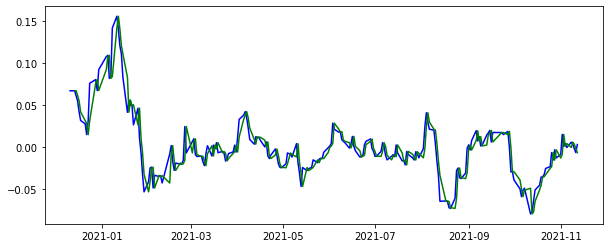

In [302]:
ts_log_moving_avg_shift = ts_log_moving_avg20.shift()
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(ts_log_moving_avg20, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

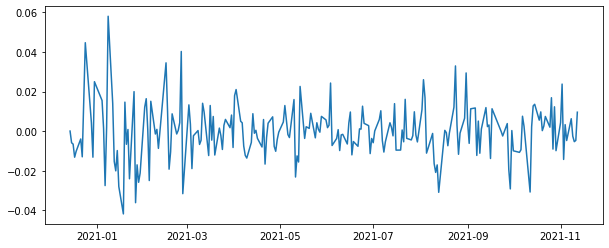

In [303]:
ts_log_moving_avg_diff = ts_log_moving_avg20 - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

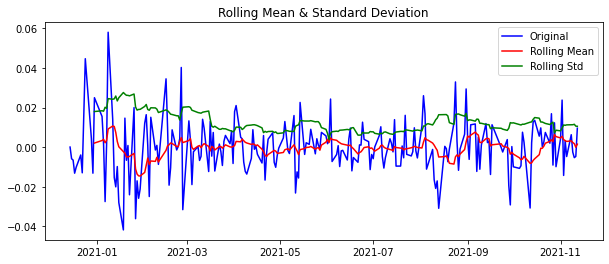

In [304]:
plot_rolling_statistics(ts_log_moving_avg_diff)

In [305]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                -5.759624e+00
p-value                        5.712381e-07
#Lags Used                     1.100000e+01
Number of Observations Used    2.140000e+02
Critical Value (1%)           -3.461282e+00
Critical Value (5%)           -2.875143e+00
Critical Value (10%)          -2.574020e+00
dtype: float64


## (4) 시계열 분해(Time series decomposition)

In [306]:
ts_log

Date
2020-11-16    11.101945
2020-11-17    11.092854
2020-11-18    11.079061
2020-11-19    11.075970
2020-11-20    11.077516
                ...    
2021-11-08    11.164785
2021-11-09    11.163368
2021-11-10    11.159104
2021-11-11    11.154821
2021-11-12    11.164785
Name: Close, Length: 246, dtype: float64

In [307]:
type(ts_log.index)

pandas.core.indexes.datetimes.DatetimeIndex

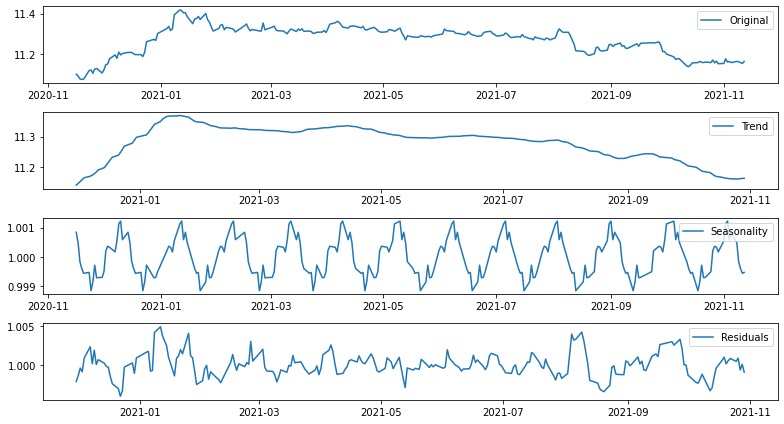

In [308]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model = 'multiplicative', freq = 20)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화)
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [309]:
residual.isna().sum()

20

In [310]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.840837e+00
p-value                        1.793019e-09
#Lags Used                     4.000000e+00
Number of Observations Used    2.210000e+02
Critical Value (1%)           -3.460291e+00
Critical Value (5%)           -2.874709e+00
Critical Value (10%)          -2.573789e+00
dtype: float64


-----

# STEP 4 : 학습, 테스트 데이터셋 생성
- 데이터를 9:1 비율로 나눠 train, test data를 생성한다.
- train data는 221, test data는 25인 것을 확인할 수 있다.

In [311]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

In [312]:
print(len(train_data))
print(len(test_data))

221
25


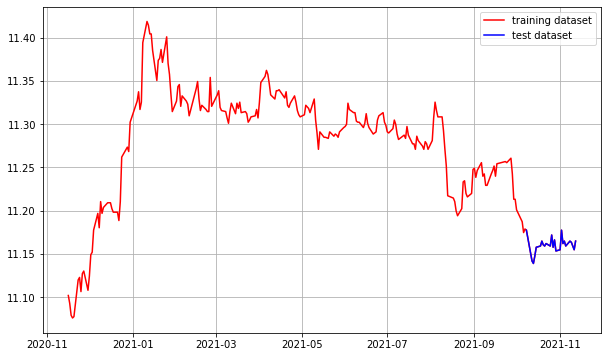

In [313]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

----

# STEP 5 : 적정 ARIMA 모수 찾기

- ACF, PACF 그려보기 -> p,q 구하기

- 차분 안정성 확인 -> d 구하기

- ACF 와 PACF 그래프를 확인해본다.

    - ACF: 그래프를 확인해보면 점차적으로 감소하는 형세를 볼 수 있다.
    - PACF: 그래프를 확인해보면 1 이후에 급격히 감소하는 것을 확인할 수 있다.
    - PACF 그래프를 통해 p = 1를 적용해보는 것을 고려할 수 있다.

- 차분을 구해보니 d = 2가 적절하지 않을까 싶긴하나 확신이 들진 않아서 d=1부터 적용해보아도 될 것 같다.


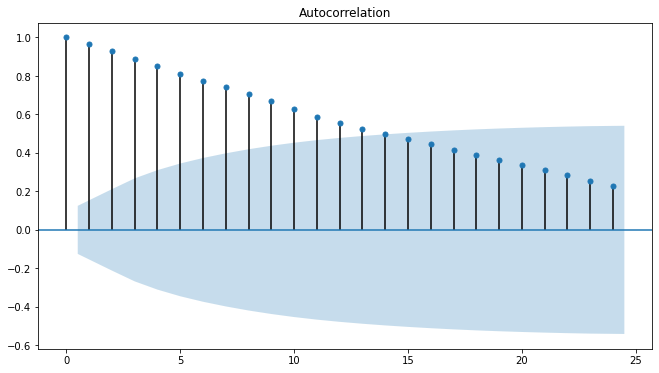

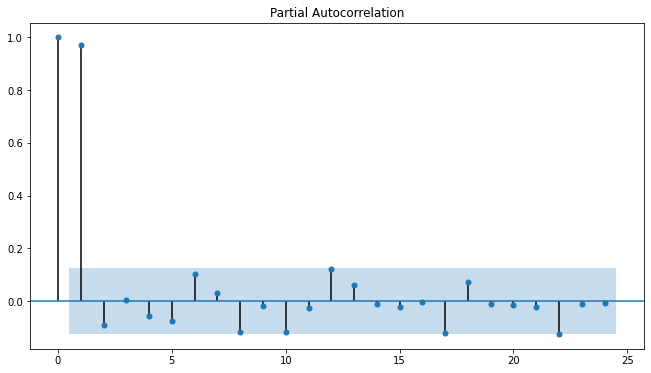

In [314]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -4.932351
p-value                          0.000030
#Lags Used                      11.000000
Number of Observations Used    233.000000
Critical Value (1%)             -3.458731
Critical Value (5%)             -2.874026
Critical Value (10%)            -2.573424
dtype: float64


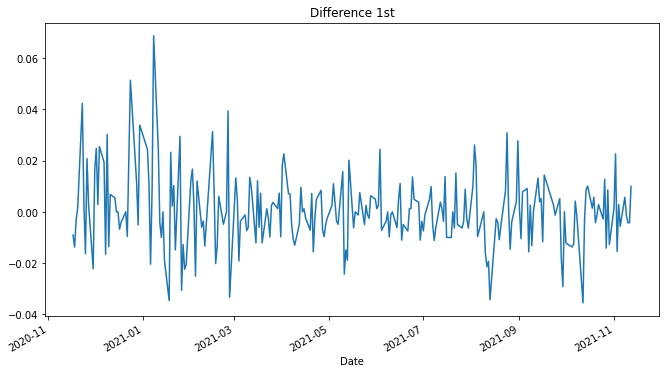

In [315]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -7.145457e+00
p-value                        3.241605e-10
#Lags Used                     1.400000e+01
Number of Observations Used    2.290000e+02
Critical Value (1%)           -3.459233e+00
Critical Value (5%)           -2.874245e+00
Critical Value (10%)          -2.573541e+00
dtype: float64


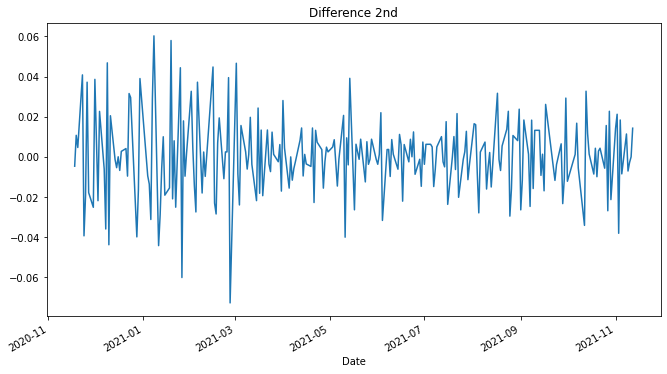

In [316]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

----
# STEP 6 : ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련

- 모델 테스트 및 플로팅

- 최종 예측 모델 정확도 측정(MAPE)

In [119]:
pip install statsmodels

In [317]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

In [318]:
from statsmodels.tsa.arima_model import ARIMA

## (1) p = 1, d =0, q = 0

In [319]:
# Build Model
model = ARIMA(train_data, order=(1, 0, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                  221
Model:                     ARMA(1, 0)   Log Likelihood                 620.363
Method:                       css-mle   S.D. of innovations              0.014
Date:                Mon, 15 Nov 2021   AIC                          -1234.725
Time:                        16:35:33   BIC                          -1224.531
Sample:                             0   HQIC                         -1230.609
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          11.2255      0.062    180.679      0.000      11.104      11.347
ar.L1.Close     0.9864      0.011     90.678      0.000       0.965       1.008
                                    Roots       

<class 'statsmodels.tsa.arima_model.ARMAResultsWrapper'>


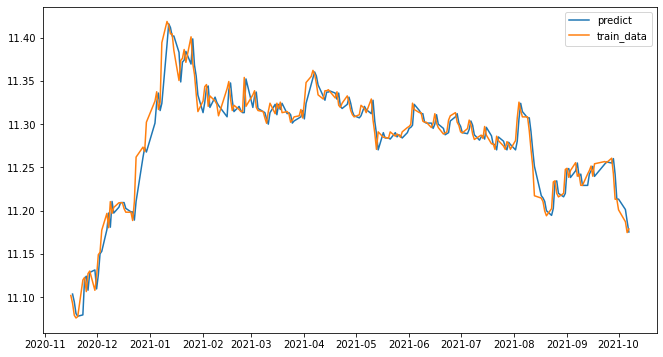

In [320]:
fitted_m2 = fitted_m.predict()
fitted_m2 = fitted_m2.drop(fitted_m2.index[0])
plt.plot(fitted_m2, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()
print(type(fitted_m))

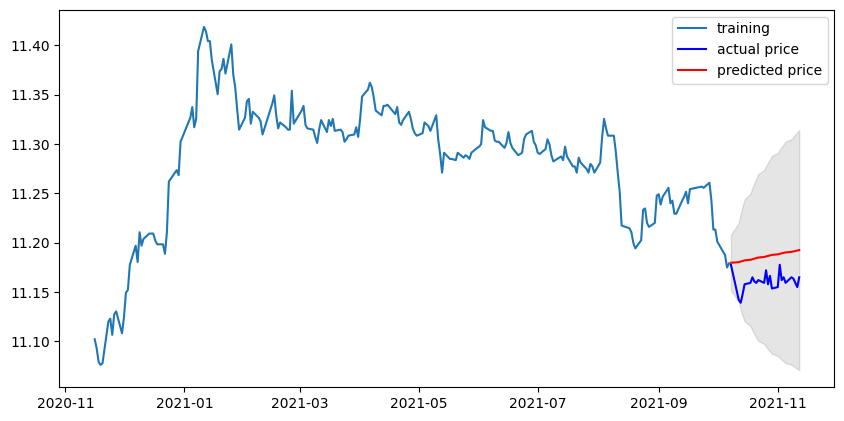

In [321]:
# Forecast : 데이터 구간의 데이터 예측
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [322]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3824249.0704527632
MAE:  1860.3149837879419
RMSE:  1955.5687332468688
MAPE: 2.65%


## (2) p = 1, d =1, q = 0

In [122]:
# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  220
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 619.334
Method:                       css-mle   S.D. of innovations              0.014
Date:                Mon, 15 Nov 2021   AIC                          -1232.668
Time:                        13:58:36   BIC                          -1222.487
Sample:                             1   HQIC                         -1228.557
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0003      0.001      0.329      0.743      -0.002       0.002
ar.L1.D.Close     0.0759      0.067      1.130      0.260      -0.056       0.207
                                    Root

<class 'statsmodels.tsa.arima_model.ARIMAResultsWrapper'>


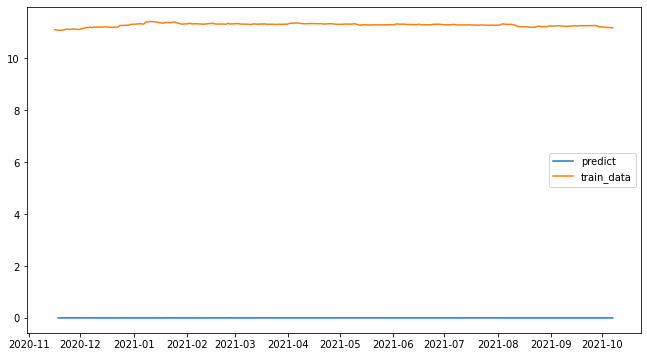

In [123]:
fitted_m2 = fitted_m.predict()
fitted_m2 = fitted_m2.drop(fitted_m2.index[0])
plt.plot(fitted_m2, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()
print(type(fitted_m))

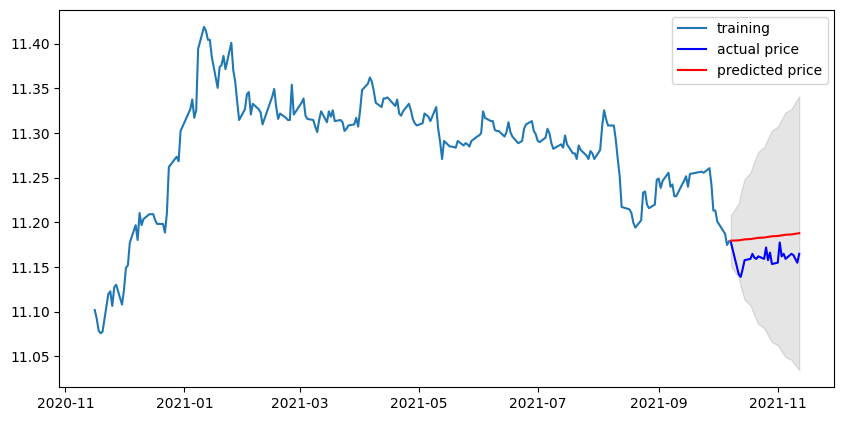

In [124]:
# Forecast : 데이터 구간의 데이터 예측
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [125]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3159772.1323345024
MAE:  1675.0553096672706
RMSE:  1777.5747895192771
MAPE: 2.39%


## (3) p = 1, d =2, q = 0

In [126]:
# Build Model
model = ARIMA(train_data, order=(1, 2, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                  219
Model:                 ARIMA(1, 2, 0)   Log Likelihood                 569.478
Method:                       css-mle   S.D. of innovations              0.018
Date:                Mon, 15 Nov 2021   AIC                          -1132.956
Time:                        13:58:36   BIC                          -1122.789
Sample:                             2   HQIC                         -1128.850
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           4.456e-05      0.001      0.052      0.959      -0.002       0.002
ar.L1.D2.Close    -0.4192      0.061     -6.848      0.000      -0.539      -0.299
                                    

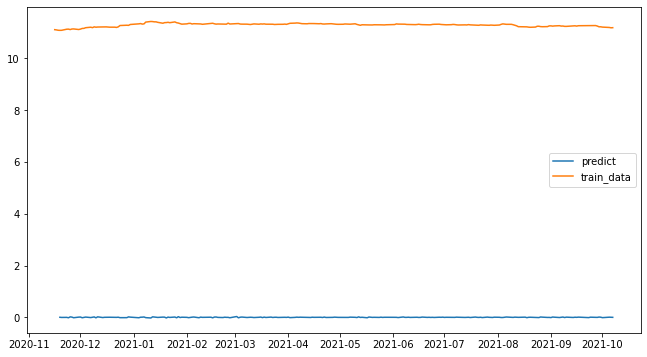

In [127]:
fitted_m2 = fitted_m.predict()
fitted_m2 = fitted_m2.drop(fitted_m2.index[0])
plt.plot(fitted_m2, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

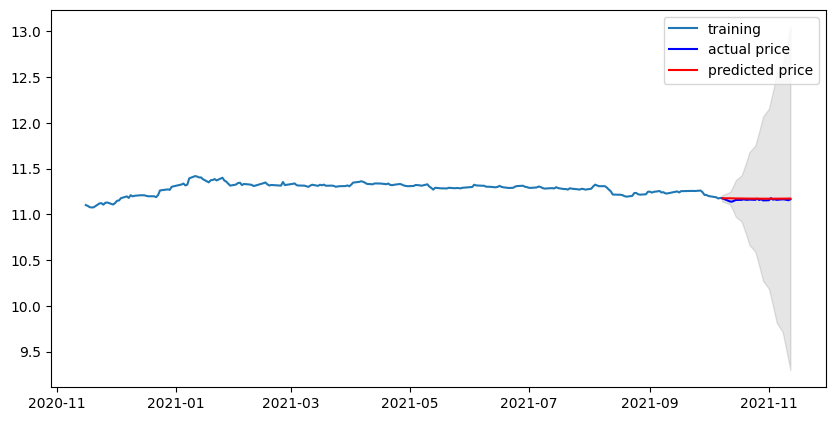

In [128]:
# Forecast : 데이터 구간의 데이터 예측
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [129]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1271520.7400068736
MAE:  954.4780342889612
RMSE:  1127.6172843686254
MAPE: 1.37%


## (4) p = 0, d =1, q = 1

In [130]:
# Build Model
model = ARIMA(train_data, order=(0, 1, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  220
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 619.455
Method:                       css-mle   S.D. of innovations              0.014
Date:                Mon, 15 Nov 2021   AIC                          -1232.910
Time:                        13:58:37   BIC                          -1222.729
Sample:                             1   HQIC                         -1228.798
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0003      0.001      0.327      0.744      -0.002       0.002
ma.L1.D.Close     0.0904      0.073      1.235      0.218      -0.053       0.234
                                    Root

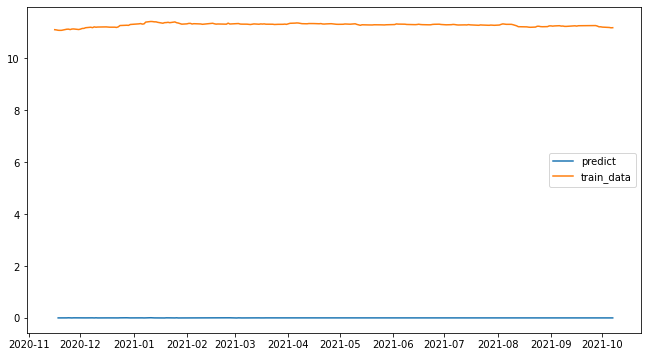

In [131]:
fitted_m2 = fitted_m.predict()
fitted_m2 = fitted_m2.drop(fitted_m2.index[0])
plt.plot(fitted_m2, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

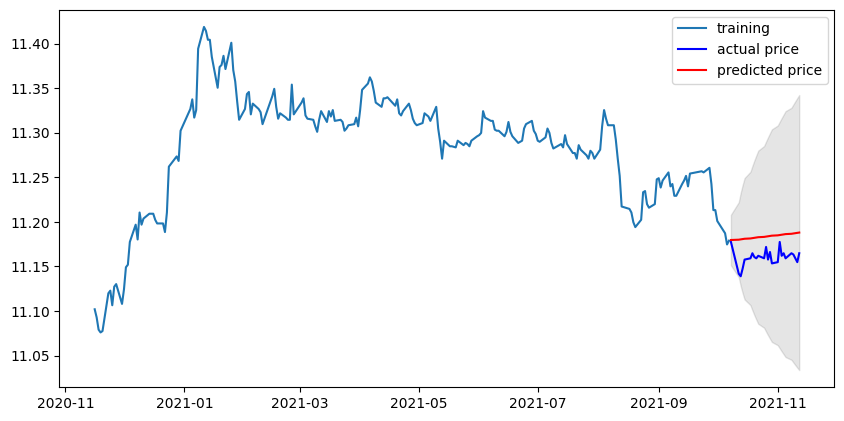

In [132]:
# Forecast : 데이터 구간의 데이터 예측
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [133]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3193107.3464334155
MAE:  1685.0318863468624
RMSE:  1786.9267882130525
MAPE: 2.41%


----

# STEP 7 : 다른 주식 종목 예측해 보기

## 1. AAPL

### STEP 1: 시계열 데이터 준비

In [479]:
dataset_filepath = '/content/drive/MyDrive/AIffel/ex14/AAPL.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)

In [480]:
ts = df['Close']
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2020-11-16    120.300003
2020-11-17    119.389999
2020-11-18    118.029999
2020-11-19    118.639999
2020-11-20    117.339996
Name: Close, dtype: float64

-----

### STEP 2: 데이터 전처리

- 결측치 확인
- 로그 변환

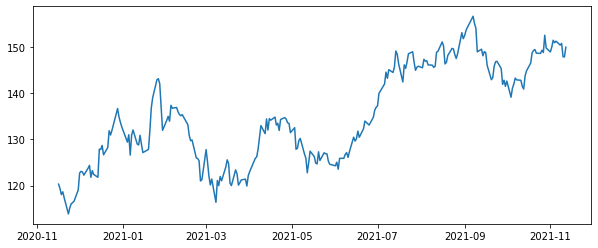

In [482]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 4

# 시계열(time series) 데이터를 차트로 그려 봅시다. 
# 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

In [483]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

Series([], Name: Close, dtype: float64)


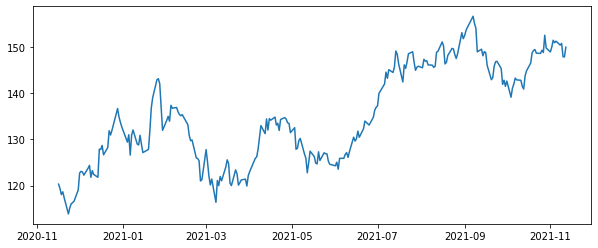

In [484]:
# 결측치가 있다면 이를 보간 
ts=ts.interpolate(method='time')

print(ts[ts.isna()])
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(ts)

In [485]:
# 로그 변환 시도 
ts_log = np.log(ts)

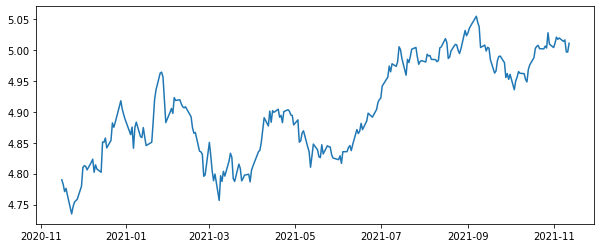

In [486]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(ts_log)

-----

### STEP 3: 시계열 안정성 분석
- 정성적 그래프 분석

- 정량적 Augmented Dicky-Fuller Test

- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

- 20일(1개월), 60일(3개월), 120일(6개월) 주기로 그래프를 확인해본다.

- 초기 p-value는 약  0.51이며, 좀 더 자세히 분석해 보았다.

- Residual 안정성을 보면 p-value가 거의 0에 가까운 값인 것을 확인할 수 있다.


In [487]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

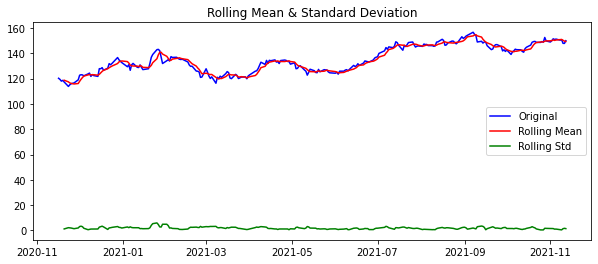

In [488]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_rolling_statistics(ts, window = 5)

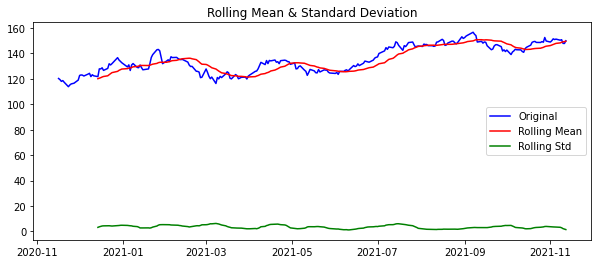

In [489]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_rolling_statistics(ts, window = 20)

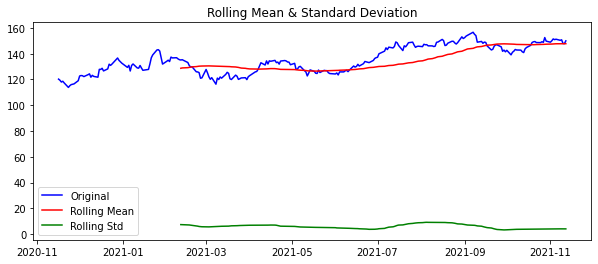

In [490]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_rolling_statistics(ts, window = 60)

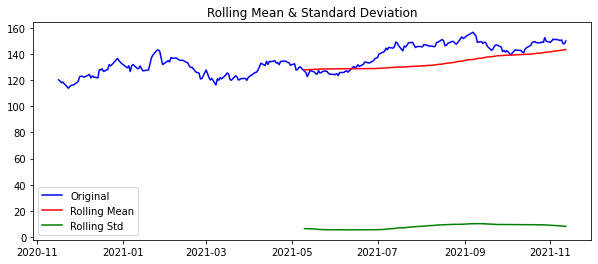

In [491]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_rolling_statistics(ts, window = 120)

In [493]:
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -1.544322
p-value                          0.511483
#Lags Used                       0.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


#### (1) 로그 함수 변환

In [494]:
ts_log = np.log(ts)

In [495]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.611362
p-value                          0.477261
#Lags Used                       0.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


#### (2) Moving average 제거 - 추세(Trend) 상쇄하기

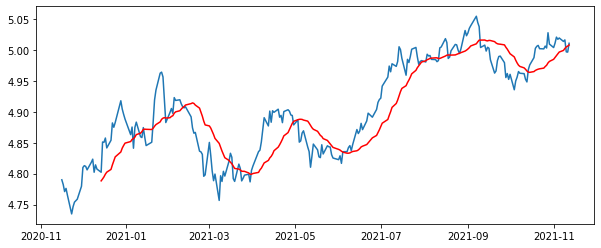

In [496]:
moving_avg20= ts_log.rolling(window=20).mean()  # moving average구하기 
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(ts_log)
plt.plot(moving_avg20, color='red')

In [497]:
ts_log_moving_avg20 = ts_log - moving_avg20 # 변화량 제거
ts_log_moving_avg20.dropna(inplace=True) # 결측치 제거
ts_log_moving_avg20.head(15)

Date
2020-12-14    0.013922
2020-12-15    0.059743
2020-12-16    0.055788
2020-12-17    0.058400
2020-12-18    0.039151
2020-12-21    0.047033
2020-12-22    0.067749
2020-12-23    0.054325
2020-12-24    0.055571
2020-12-28    0.082759
2020-12-29    0.063117
2020-12-30    0.050261
2020-12-31    0.038770
2021-01-04    0.011176
2021-01-05    0.020003
Name: Close, dtype: float64

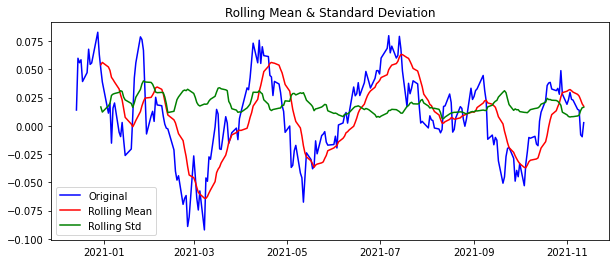

In [498]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_rolling_statistics(ts_log_moving_avg20)

In [499]:
augmented_dickey_fuller_test(ts_log_moving_avg20)

Results of Dickey-Fuller Test:
Test Statistic                  -3.265050
p-value                          0.016515
#Lags Used                       0.000000
Number of Observations Used    231.000000
Critical Value (1%)             -3.458980
Critical Value (5%)             -2.874135
Critical Value (10%)            -2.573482
dtype: float64


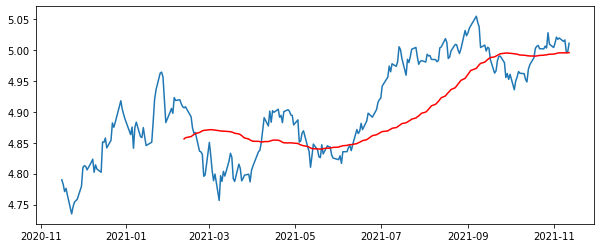

In [500]:
moving_avg60= ts_log.rolling(window=60).mean()  # moving average구하기 
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(ts_log)
plt.plot(moving_avg60, color='red')

In [501]:
ts_log_moving_avg60 = ts_log - moving_avg60 # 변화량 제거
ts_log_moving_avg60.dropna(inplace=True) # 결측치 제거
ts_log_moving_avg60.head(15)

Date
2021-02-11    0.050211
2021-02-12    0.050018
2021-02-16    0.031960
2021-02-17    0.012441
2021-02-18    0.002281
2021-02-19    0.001822
2021-02-22   -0.030120
2021-02-23   -0.032711
2021-02-24   -0.038059
2021-02-25   -0.074078
2021-02-26   -0.072155
2021-03-01   -0.020379
2021-03-02   -0.041768
2021-03-03   -0.066409
2021-03-04   -0.082055
Name: Close, dtype: float64

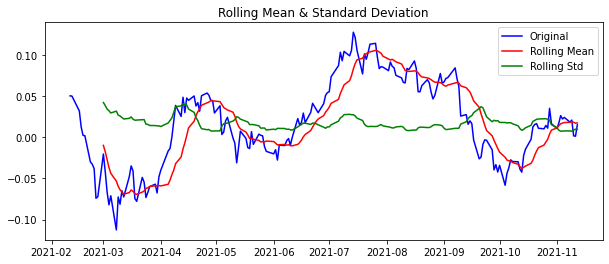

In [502]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_rolling_statistics(ts_log_moving_avg60)

In [503]:
augmented_dickey_fuller_test(ts_log_moving_avg60)

Results of Dickey-Fuller Test:
Test Statistic                  -2.135044
p-value                          0.230659
#Lags Used                       6.000000
Number of Observations Used    185.000000
Critical Value (1%)             -3.466201
Critical Value (5%)             -2.877293
Critical Value (10%)            -2.575168
dtype: float64


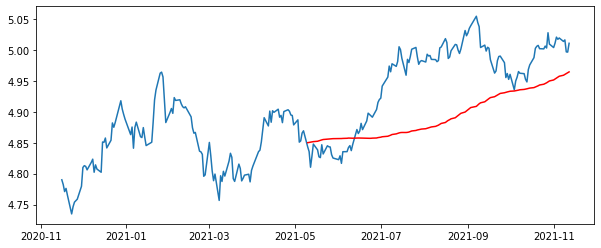

In [504]:
moving_avg120= ts_log.rolling(window=120).mean()  # moving average구하기 
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(ts_log)
plt.plot(moving_avg120, color='red')

In [505]:
ts_log_moving_avg120 = ts_log - moving_avg120 # 변화량 제거
ts_log_moving_avg120.dropna(inplace=True) # 결측치 제거
ts_log_moving_avg120.head(15)

Date
2021-05-10   -0.006978
2021-05-11   -0.014796
2021-05-12   -0.040283
2021-05-13   -0.022998
2021-05-14   -0.003945
2021-05-17   -0.013858
2021-05-18   -0.025936
2021-05-19   -0.027880
2021-05-20   -0.007859
2021-05-21   -0.023345
2021-05-24   -0.010664
2021-05-25   -0.012518
2021-05-26   -0.013163
2021-05-27   -0.025774
2021-05-28   -0.031296
Name: Close, dtype: float64

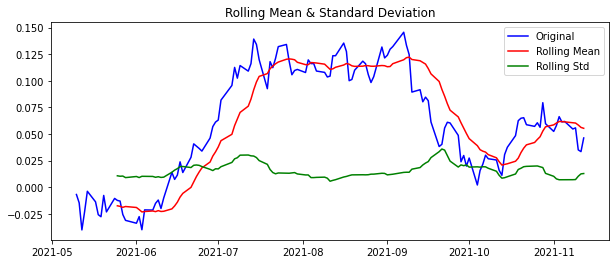

In [506]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_rolling_statistics(ts_log_moving_avg120)

In [507]:
augmented_dickey_fuller_test(ts_log_moving_avg120)

Results of Dickey-Fuller Test:
Test Statistic                  -1.627312
p-value                          0.468898
#Lags Used                       0.000000
Number of Observations Used    131.000000
Critical Value (1%)             -3.481282
Critical Value (5%)             -2.883868
Critical Value (10%)            -2.578677
dtype: float64


#### (3) 차분(Differencing) - 계절성(Seasonality) 상쇄하기

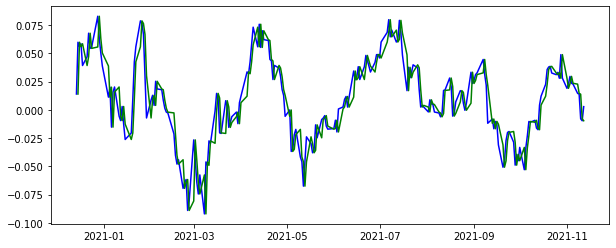

In [508]:
ts_log_moving_avg_shift = ts_log_moving_avg20.shift()
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(ts_log_moving_avg20, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

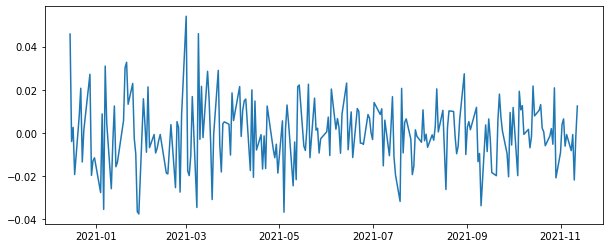

In [509]:
ts_log_moving_avg_diff = ts_log_moving_avg20 - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

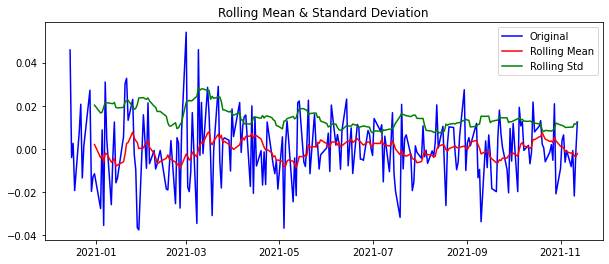

In [510]:
plot_rolling_statistics(ts_log_moving_avg_diff)

In [511]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                -1.633626e+01
p-value                        3.026587e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.300000e+02
Critical Value (1%)           -3.459106e+00
Critical Value (5%)           -2.874190e+00
Critical Value (10%)          -2.573512e+00
dtype: float64


#### (4) 시계열 분해(Time series decomposition)

In [512]:
ts_log

Date
2020-11-16    4.789989
2020-11-17    4.782395
2020-11-18    4.770939
2020-11-19    4.776094
2020-11-20    4.765076
                ...   
2021-11-08    5.013564
2021-11-09    5.016021
2021-11-10    4.996672
2021-11-11    4.996333
2021-11-12    5.010569
Name: Close, Length: 251, dtype: float64

In [513]:
type(ts_log.index)

pandas.core.indexes.datetimes.DatetimeIndex

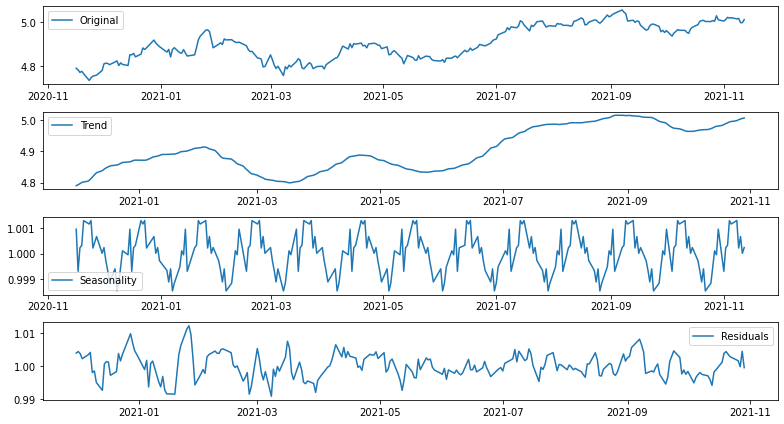

In [514]:
decomposition = seasonal_decompose(ts_log, model = 'multiplicative', freq = 20)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화)
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [515]:
residual.isna().sum()

20

In [516]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.797987e+00
p-value                        2.274977e-09
#Lags Used                     4.000000e+00
Number of Observations Used    2.260000e+02
Critical Value (1%)           -3.459620e+00
Critical Value (5%)           -2.874415e+00
Critical Value (10%)          -2.573632e+00
dtype: float64


---
### STEP 4 : 학습, 테스트 데이터셋 생성

- 데이터를 9:1 비율로 나눠 train, test data를 생성한다.
- train data는 225, test data는 26인 것을 확인할 수 있다.

In [517]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

In [518]:
print(len(train_data))
print(len(test_data))

225
26


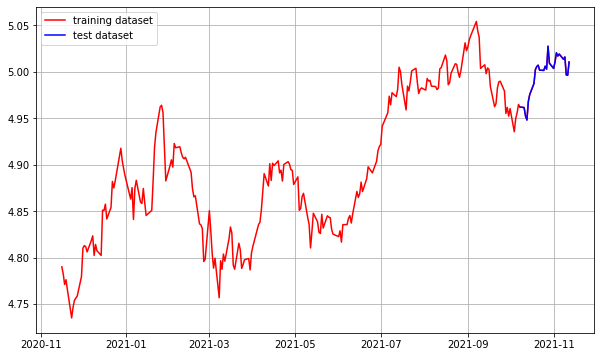

In [520]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

---
### STEP 5 : 적정 ARIMA 모수 찾기

- ACF, PACF 그려보기 -> p,q 구하기

- 차분 안정성 확인 -> d 구하기

- ACF 와 PACF 그래프를 확인해본다.

    - ACF: 그래프를 확인해보면 점차적으로 감소하는 형세를 볼 수 있다.
    - PACF: 그래프를 확인해보면 1 이후에 급격히 감소하는 것을 확인할 수 있다.
    - PACF 그래프를 통해 p = 1를 적용해보는 것을 고려할 수 있다.

- 차분을 구해보니 이번에도 d = 2가 좋지 않을까 싶다.

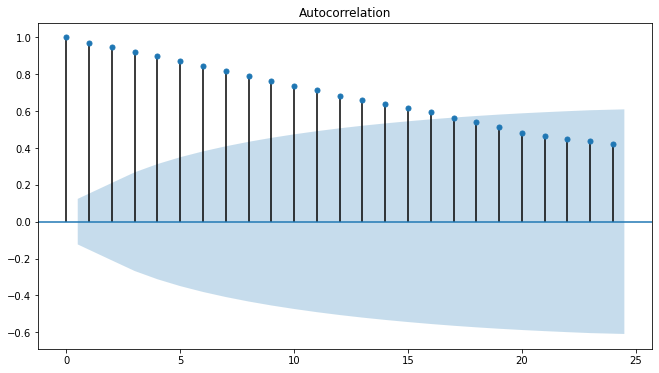

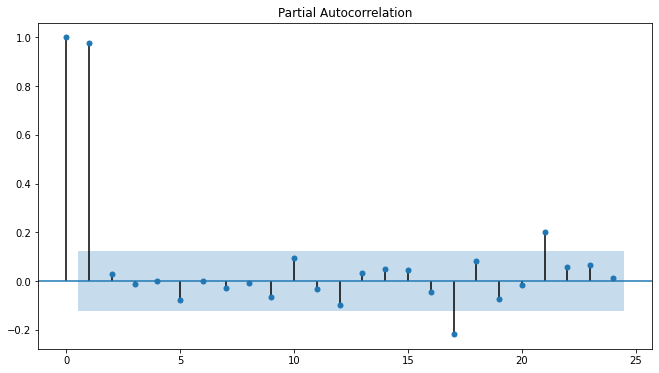

In [521]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.646950e+01
p-value                        2.290167e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.490000e+02
Critical Value (1%)           -3.456888e+00
Critical Value (5%)           -2.873219e+00
Critical Value (10%)          -2.572994e+00
dtype: float64


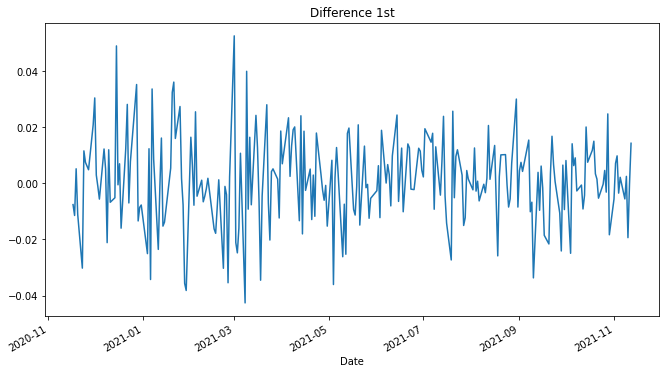

In [522]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -7.546007e+00
p-value                        3.282277e-11
#Lags Used                     1.400000e+01
Number of Observations Used    2.340000e+02
Critical Value (1%)           -3.458608e+00
Critical Value (5%)           -2.873972e+00
Critical Value (10%)          -2.573396e+00
dtype: float64


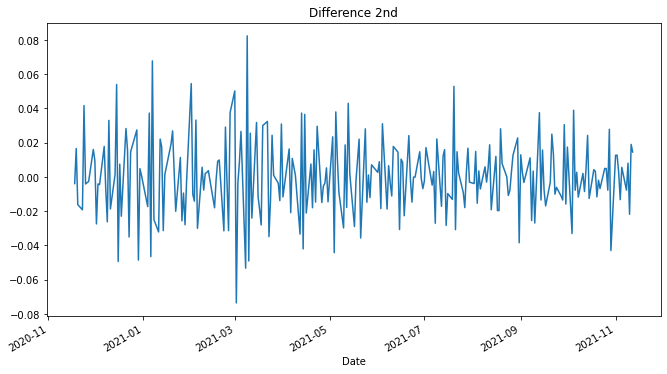

In [523]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

----
### STEP 6 : ARIMA 모델 훈련과 테스트

#### (1) p = 1, d =0, q = 0

In [525]:
# Build Model
model = ARIMA(train_data, order=(1, 0, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                  225
Model:                     ARMA(1, 0)   Log Likelihood                 609.290
Method:                       css-mle   S.D. of innovations              0.016
Date:                Mon, 15 Nov 2021   AIC                          -1212.581
Time:                        17:17:10   BIC                          -1202.332
Sample:                             0   HQIC                         -1208.444
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.8886      0.042    115.442      0.000       4.806       4.972
ar.L1.Close     0.9787      0.013     76.287      0.000       0.954       1.004
                                    Roots       

<class 'statsmodels.tsa.arima_model.ARMAResultsWrapper'>


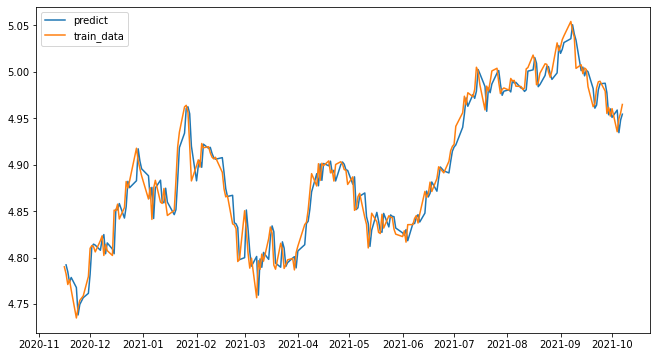

In [526]:
fitted_m2 = fitted_m.predict()
fitted_m2 = fitted_m2.drop(fitted_m2.index[0])
plt.plot(fitted_m2, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()
print(type(fitted_m))

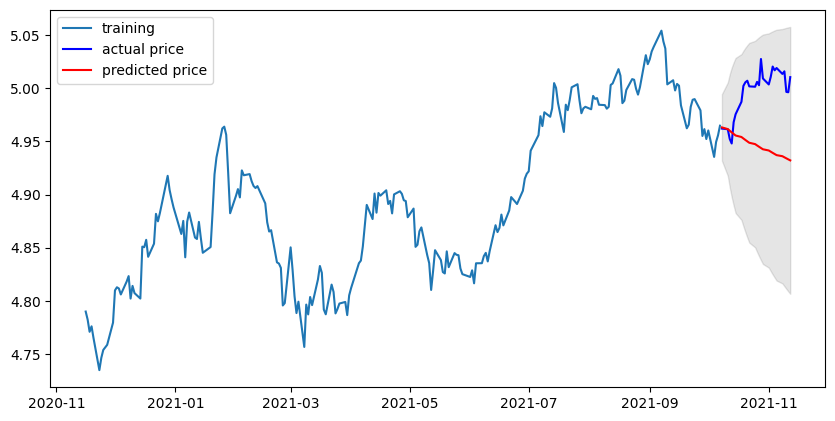

In [527]:
# Forecast : 데이터 구간의 데이터 예측
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [528]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  72.21750275859166
MAE:  7.552011591553947
RMSE:  8.498088182561515
MAPE: 5.05%


#### (2) p = 1, d =1, q = 0

In [529]:
# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 607.538
Method:                       css-mle   S.D. of innovations              0.016
Date:                Mon, 15 Nov 2021   AIC                          -1209.076
Time:                        17:17:38   BIC                          -1198.841
Sample:                             1   HQIC                         -1204.945
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0008      0.001      0.761      0.447      -0.001       0.003
ar.L1.D.Close    -0.0465      0.067     -0.698      0.486      -0.177       0.084
                                    Root

<class 'statsmodels.tsa.arima_model.ARIMAResultsWrapper'>


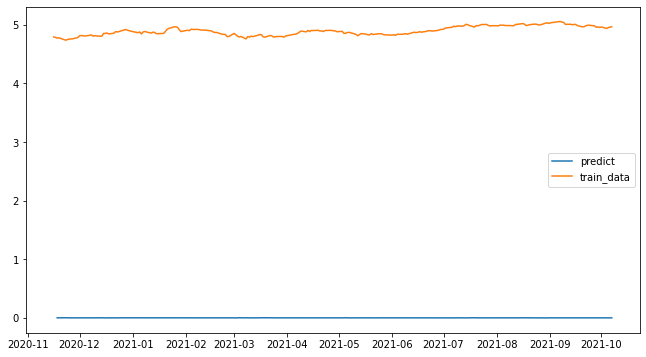

In [530]:
fitted_m2 = fitted_m.predict()
fitted_m2 = fitted_m2.drop(fitted_m2.index[0])
plt.plot(fitted_m2, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()
print(type(fitted_m))

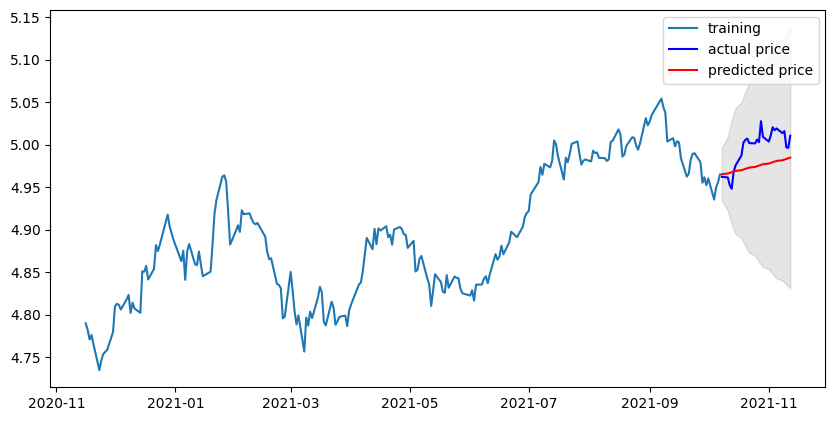

In [531]:
# Forecast : 데이터 구간의 데이터 예측
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [532]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  17.34467276394414
MAE:  3.717103699421818
RMSE:  4.164693597846561
MAPE: 2.49%


#### (3) p = 1, d =2, q = 0

In [533]:
# Build Model
model = ARIMA(train_data, order=(1, 2, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                  223
Model:                 ARIMA(1, 2, 0)   Log Likelihood                 555.554
Method:                       css-mle   S.D. of innovations              0.020
Date:                Mon, 15 Nov 2021   AIC                          -1105.109
Time:                        17:17:57   BIC                          -1094.887
Sample:                             2   HQIC                         -1100.982
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           7.651e-05      0.001      0.086      0.932      -0.002       0.002
ar.L1.D2.Close    -0.5095      0.057     -8.889      0.000      -0.622      -0.397
                                    

<class 'statsmodels.tsa.arima_model.ARIMAResultsWrapper'>


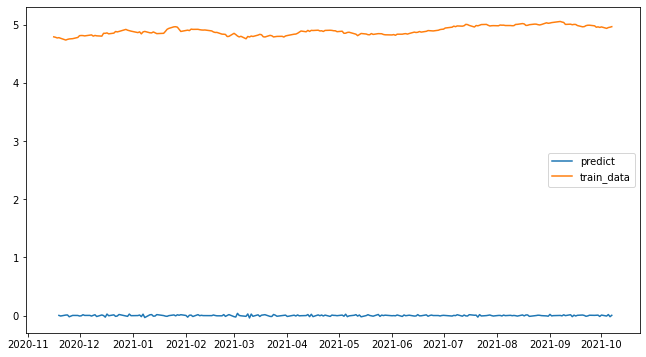

In [534]:
fitted_m2 = fitted_m.predict()
fitted_m2 = fitted_m2.drop(fitted_m2.index[0])
plt.plot(fitted_m2, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()
print(type(fitted_m))

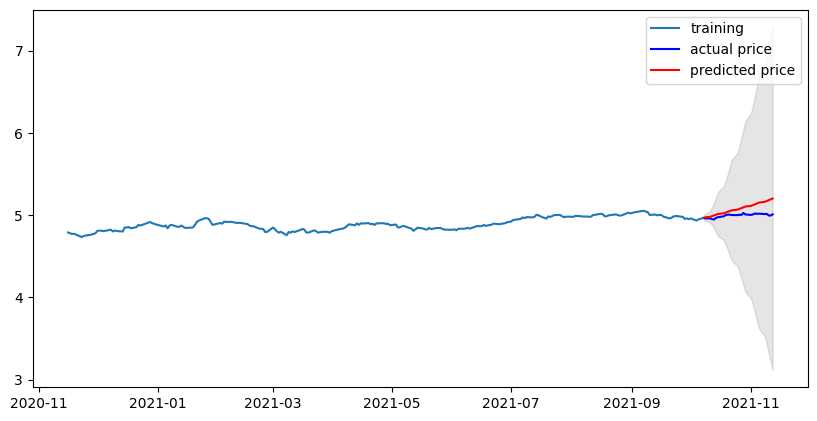

In [535]:
# Forecast : 데이터 구간의 데이터 예측
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [536]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  274.71469862301865
MAE:  13.802323059904118
RMSE:  16.574519559342246
MAPE: 9.26%


#### (4) p = 0, d =1, q = 1

In [537]:
# Build Model
model = ARIMA(train_data, order=(0, 1, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 607.552
Method:                       css-mle   S.D. of innovations              0.016
Date:                Mon, 15 Nov 2021   AIC                          -1209.104
Time:                        17:18:25   BIC                          -1198.869
Sample:                             1   HQIC                         -1204.973
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0008      0.001      0.765      0.445      -0.001       0.003
ma.L1.D.Close    -0.0493      0.069     -0.717      0.474      -0.184       0.085
                                    Root

<class 'statsmodels.tsa.arima_model.ARIMAResultsWrapper'>


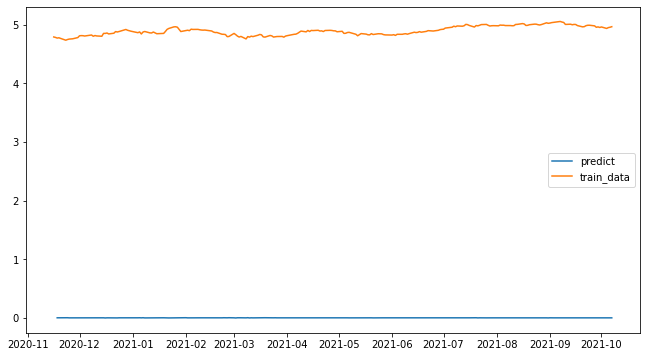

In [538]:
fitted_m2 = fitted_m.predict()
fitted_m2 = fitted_m2.drop(fitted_m2.index[0])
plt.plot(fitted_m2, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()
print(type(fitted_m))

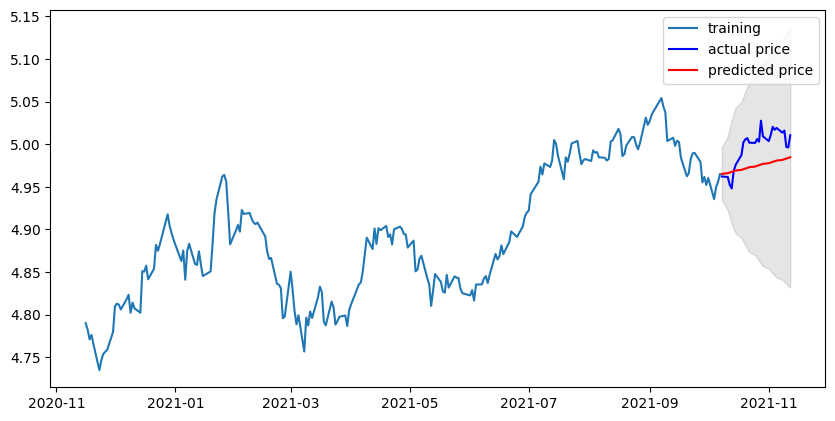

In [539]:
# Forecast : 데이터 구간의 데이터 예측
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [540]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  17.39547970801363
MAE:  3.7219729686297995
RMSE:  4.170788859198417
MAPE: 2.49%


## 2. TSLA

### STEP 1: 시계열 데이터 준비

In [542]:
dataset_filepath = '/content/drive/MyDrive/AIffel/ex14/TSLA.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)

In [543]:
ts = df['Close']

-----

### STEP 2: 데이터 전처리

- 결측치 확인

- 로그 변환

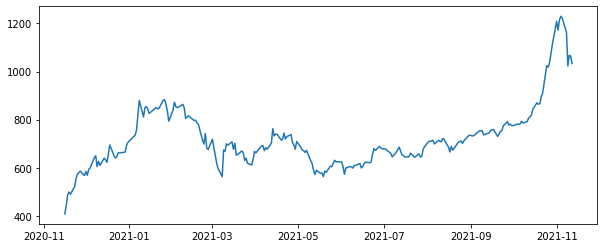

In [544]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 4
plt.plot(ts)

Series([], Name: Close, dtype: float64)


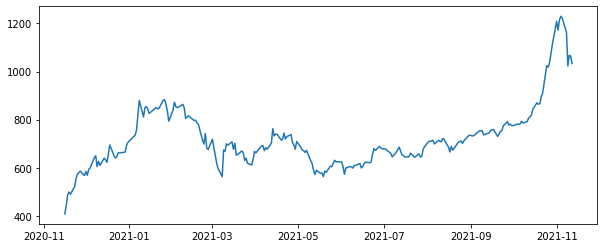

In [545]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

# 결측치가 있다면 이를 보간 
ts=ts.interpolate(method='time')

print(ts[ts.isna()])
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(ts)

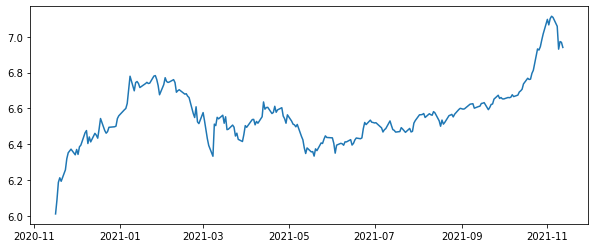

In [546]:
# 로그 변환 시도 
ts_log = np.log(ts)
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(ts_log)

-----

### STEP 3: 시계열 안정성 분석

- 정성적 그래프 분석

- 정량적 Augmented Dicky-Fuller Test

- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

- 20일(1개월), 60일(3개월), 120일(6개월) 주기로 그래프를 확인해본다.

- 초기 p-value는 약 0.41이며, 좀 더 자세히 분석해 보았다.

- Residual 안정성을 보면 p-value가 거의 0에 가까운 값인 것을 확인할 수 있다.

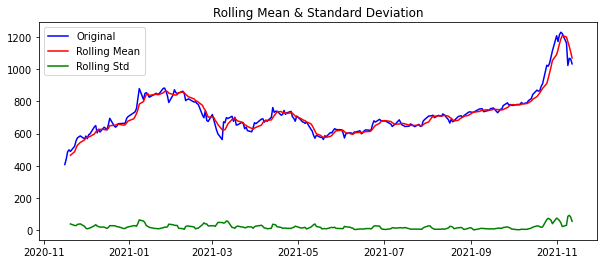

In [547]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_rolling_statistics(ts, window = 5)

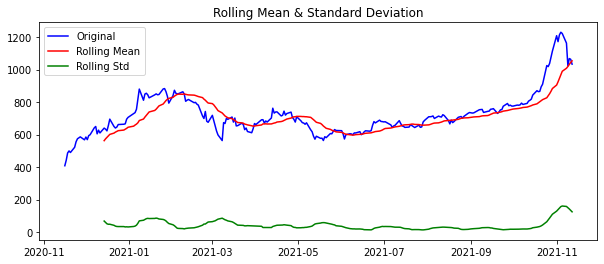

In [548]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_rolling_statistics(ts, window = 20)

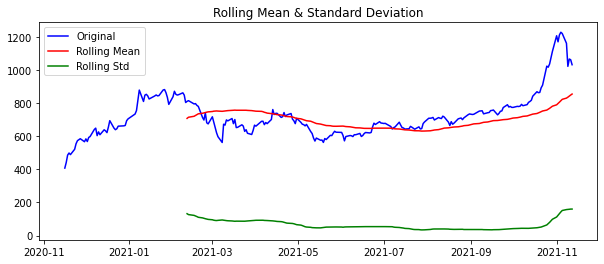

In [549]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_rolling_statistics(ts, window = 60)

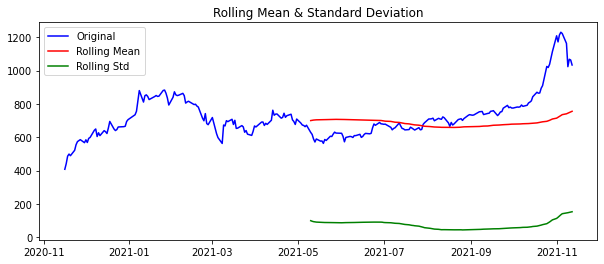

In [550]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_rolling_statistics(ts, window = 120)

In [551]:
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -1.724620
p-value                          0.418474
#Lags Used                      11.000000
Number of Observations Used    239.000000
Critical Value (1%)             -3.458011
Critical Value (5%)             -2.873710
Critical Value (10%)            -2.573256
dtype: float64


#### (1) 로그 함수 변환

In [552]:
ts_log = np.log(ts)

In [553]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -2.584096
p-value                          0.096329
#Lags Used                       0.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


#### (2) Moving average 제거 - 추세(Trend) 상쇄하기

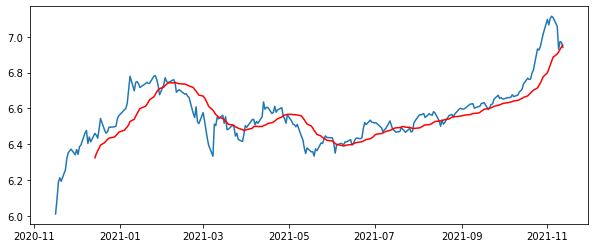

In [554]:
moving_avg20= ts_log.rolling(window=20).mean()  # moving average구하기 
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(ts_log)
plt.plot(moving_avg20, color='red')

In [555]:
ts_log_moving_avg20 = ts_log - moving_avg20 # 변화량 제거
ts_log_moving_avg20.dropna(inplace=True) # 결측치 제거
ts_log_moving_avg20.head(15)

Date
2020-12-14    0.136343
2020-12-15    0.104037
2020-12-16    0.070162
2020-12-17    0.107068
2020-12-18    0.148434
2020-12-21    0.067121
2020-12-22    0.042133
2020-12-23    0.043346
2020-12-24    0.060381
2020-12-28    0.057033
2020-12-29    0.052500
2020-12-30    0.086201
2020-12-31    0.090974
2021-01-04    0.114211
2021-01-05    0.111267
Name: Close, dtype: float64

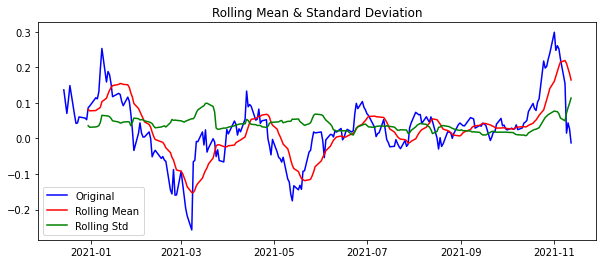

In [556]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_rolling_statistics(ts_log_moving_avg20)

In [557]:
augmented_dickey_fuller_test(ts_log_moving_avg20)

Results of Dickey-Fuller Test:
Test Statistic                  -3.088520
p-value                          0.027414
#Lags Used                       0.000000
Number of Observations Used    231.000000
Critical Value (1%)             -3.458980
Critical Value (5%)             -2.874135
Critical Value (10%)            -2.573482
dtype: float64


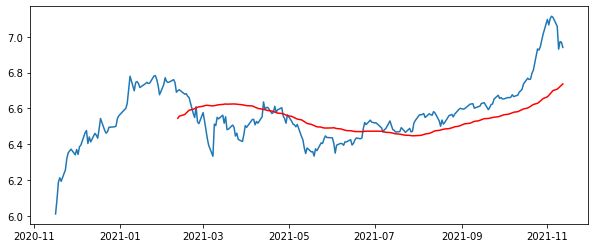

In [558]:
moving_avg60= ts_log.rolling(window=60).mean()  # moving average구하기 
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(ts_log)
plt.plot(moving_avg60, color='red')

In [559]:
ts_log_moving_avg60 = ts_log - moving_avg60 # 변화량 제거
ts_log_moving_avg60.dropna(inplace=True) # 결측치 제거
ts_log_moving_avg60.head(15)

Date
2021-02-11    0.153869
2021-02-12    0.147798
2021-02-16    0.113288
2021-02-17    0.107463
2021-02-18    0.086285
2021-02-19    0.070744
2021-02-22   -0.023869
2021-02-23   -0.049860
2021-02-24    0.005815
2021-02-25   -0.080750
2021-02-26   -0.093549
2021-03-01   -0.035365
2021-03-02   -0.084047
2021-03-03   -0.135283
2021-03-04   -0.185739
Name: Close, dtype: float64

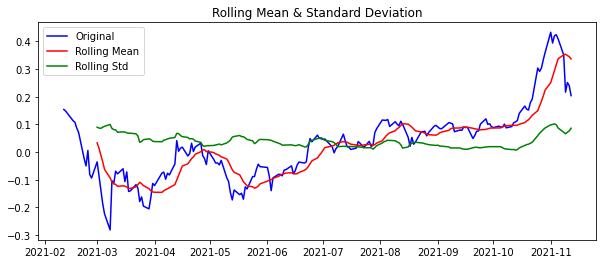

In [560]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_rolling_statistics(ts_log_moving_avg60)

In [561]:
augmented_dickey_fuller_test(ts_log_moving_avg60)

Results of Dickey-Fuller Test:
Test Statistic                  -1.170267
p-value                          0.686254
#Lags Used                      11.000000
Number of Observations Used    180.000000
Critical Value (1%)             -3.467211
Critical Value (5%)             -2.877735
Critical Value (10%)            -2.575403
dtype: float64


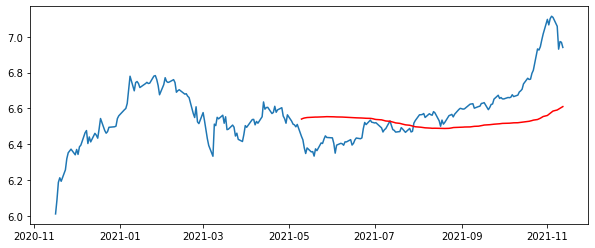

In [562]:
moving_avg120= ts_log.rolling(window=120).mean()  # moving average구하기 
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(ts_log)
plt.plot(moving_avg120, color='red')

In [563]:
ts_log_moving_avg120 = ts_log - moving_avg120 # 변화량 제거
ts_log_moving_avg120.dropna(inplace=True) # 결측치 제거
ts_log_moving_avg120.head(15)

Date
2021-05-10   -0.096633
2021-05-11   -0.119082
2021-05-12   -0.166751
2021-05-13   -0.199433
2021-05-14   -0.169736
2021-05-17   -0.193236
2021-05-18   -0.192285
2021-05-19   -0.217657
2021-05-20   -0.177287
2021-05-21   -0.187323
2021-05-24   -0.144813
2021-05-25   -0.147983
2021-05-26   -0.125089
2021-05-27   -0.106847
2021-05-28   -0.116168
Name: Close, dtype: float64

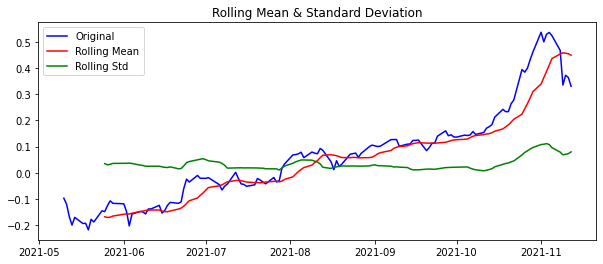

In [564]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_rolling_statistics(ts_log_moving_avg120)

In [565]:
augmented_dickey_fuller_test(ts_log_moving_avg120)

Results of Dickey-Fuller Test:
Test Statistic                   0.380691
p-value                          0.980758
#Lags Used                      11.000000
Number of Observations Used    120.000000
Critical Value (1%)             -3.486056
Critical Value (5%)             -2.885943
Critical Value (10%)            -2.579785
dtype: float64


#### (3) 차분(Differencing) - 계절성(Seasonality) 상쇄하기

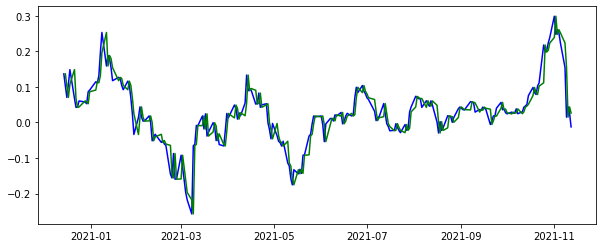

In [566]:
ts_log_moving_avg_shift = ts_log_moving_avg20.shift()
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(ts_log_moving_avg20, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

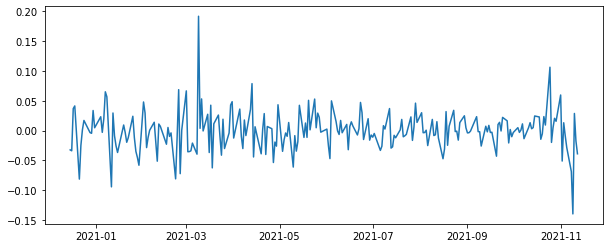

In [567]:
ts_log_moving_avg_diff = ts_log_moving_avg20 - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

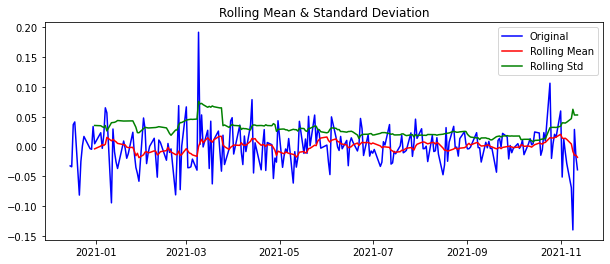

In [568]:
plot_rolling_statistics(ts_log_moving_avg_diff)

In [569]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                -1.602099e+01
p-value                        6.204775e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.300000e+02
Critical Value (1%)           -3.459106e+00
Critical Value (5%)           -2.874190e+00
Critical Value (10%)          -2.573512e+00
dtype: float64


#### (4) 시계열 분해(Time series decomposition)

In [570]:
ts_log

Date
2020-11-16    6.011488
2020-11-17    6.090427
2020-11-18    6.187525
2020-11-19    6.213147
2020-11-20    6.193609
                ...   
2021-11-08    7.058707
2021-11-09    6.930983
2021-11-10    6.973496
2021-11-11    6.969330
2021-11-12    6.940629
Name: Close, Length: 251, dtype: float64

In [571]:
type(ts_log.index)

pandas.core.indexes.datetimes.DatetimeIndex

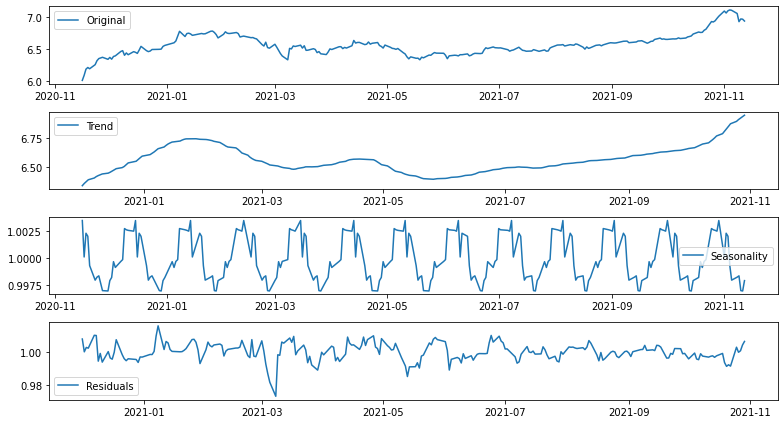

In [572]:
decomposition = seasonal_decompose(ts_log, model = 'multiplicative', freq = 20)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화)
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [573]:
residual.isna().sum()

20

In [574]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -5.903136e+00
p-value                        2.747936e-07
#Lags Used                     6.000000e+00
Number of Observations Used    2.240000e+02
Critical Value (1%)           -3.459885e+00
Critical Value (5%)           -2.874531e+00
Critical Value (10%)          -2.573694e+00
dtype: float64


---
### STEP 4 : 학습, 테스트 데이터셋 생성
- 데이터를 9:1 비율로 나눠 train, test data를 생성한다.
- train data는 225, test data는 26인 것을 확인할 수 있다.

In [575]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

In [576]:
print(len(train_data))
print(len(test_data))

225
26


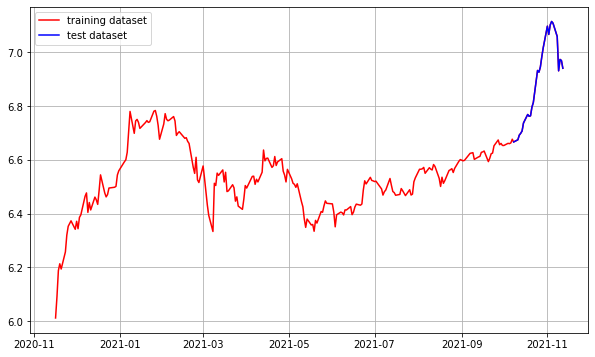

In [577]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

---
### STEP 5 : 적정 ARIMA 모수 찾기
- ACF, PACF 그려보기 -> p,q 구하기

- 차분 안정성 확인 -> d 구하기

- ACF 와 PACF 그래프를 확인해본다.

    - ACF: 그래프를 확인해보면 점차적으로 감소하는 형세를 볼 수 있다.
    - PACF: 그래프를 확인해보면 1 이후에 급격히 감소하는 것을 확인할 수 있다.
    - PACF 그래프를 통해 p = 1를 적용해보는 것을 고려할 수 있다.

- 차분을 구해보니 d = 2가 적절하지 않을까 싶긴하나 확신이 들진 않아서 d=1부터 적용해보아도 될 것 같다.

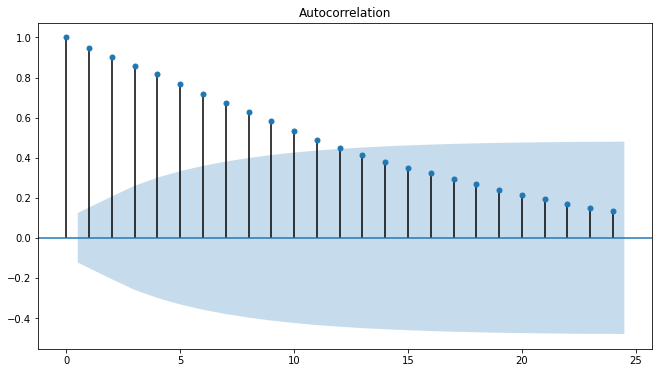

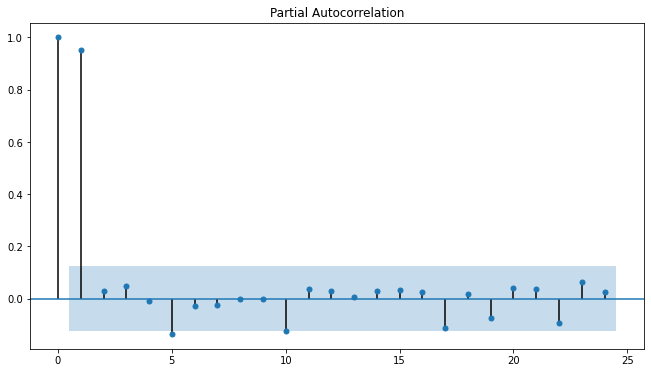

In [578]:
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.642320e+01
p-value                        2.518966e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.490000e+02
Critical Value (1%)           -3.456888e+00
Critical Value (5%)           -2.873219e+00
Critical Value (10%)          -2.572994e+00
dtype: float64


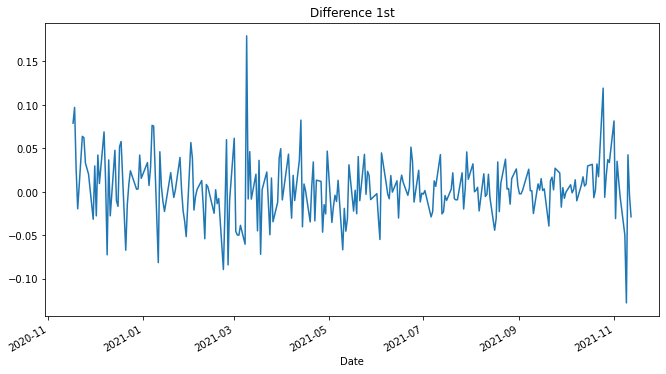

In [579]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -6.713403e+00
p-value                        3.632513e-09
#Lags Used                     1.400000e+01
Number of Observations Used    2.340000e+02
Critical Value (1%)           -3.458608e+00
Critical Value (5%)           -2.873972e+00
Critical Value (10%)          -2.573396e+00
dtype: float64


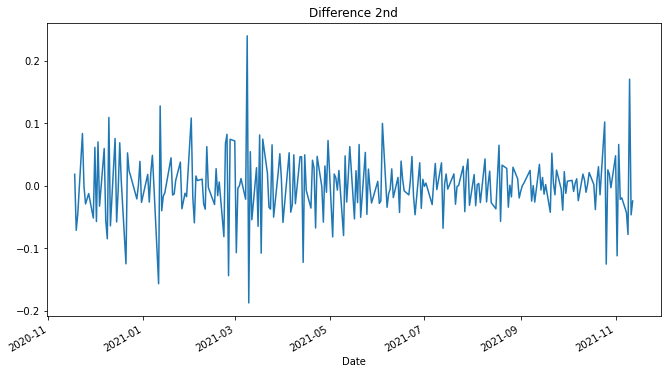

In [580]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

----
### STEP 6 : ARIMA 모델 훈련과 테스트

#### (1) p = 1, d =0, q = 0

In [644]:
# Build Model
model = ARIMA(train_data, order=(1, 0, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                  225
Model:                     ARMA(1, 0)   Log Likelihood                 691.773
Method:                       css-mle   S.D. of innovations              0.011
Date:                Mon, 15 Nov 2021   AIC                          -1377.547
Time:                        18:01:04   BIC                          -1367.298
Sample:                             0   HQIC                         -1373.410
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           3.8945      0.095     41.059      0.000       3.709       4.080
ar.L1.Close     0.9954      0.005    203.372      0.000       0.986       1.005
                                    Roots       

<class 'statsmodels.tsa.arima_model.ARMAResultsWrapper'>


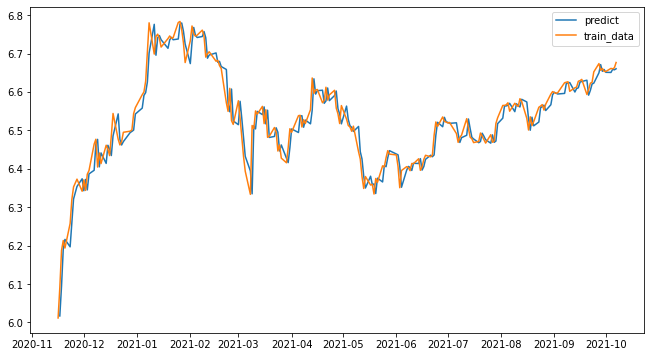

In [582]:
fitted_m2 = fitted_m.predict()
fitted_m2 = fitted_m2.drop(fitted_m2.index[0])
plt.plot(fitted_m2, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()
print(type(fitted_m))

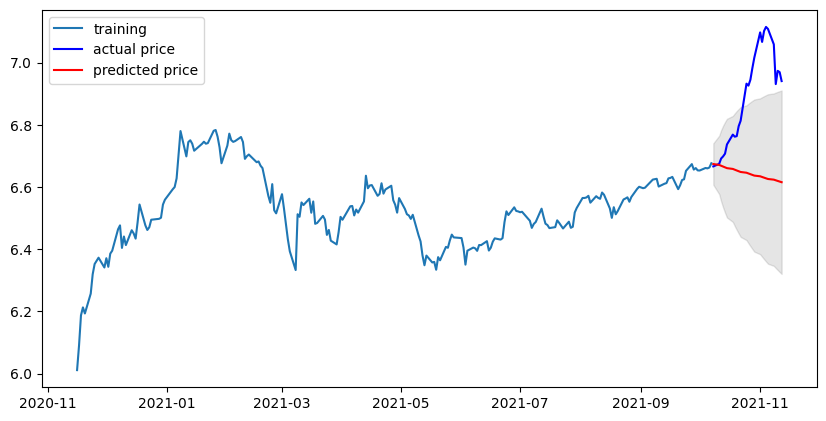

In [583]:
# Forecast : 데이터 구간의 데이터 예측
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [584]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  78236.3602808191
MAE:  229.97846220048862
RMSE:  279.70763357623815
MAPE: 21.15%


#### (2) p = 1, d =1, q = 0

In [585]:
# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 440.239
Method:                       css-mle   S.D. of innovations              0.034
Date:                Mon, 15 Nov 2021   AIC                           -874.477
Time:                        17:22:14   BIC                           -864.242
Sample:                             1   HQIC                          -870.346
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0029      0.002      1.379      0.169      -0.001       0.007
ar.L1.D.Close    -0.0598      0.067     -0.888      0.375      -0.192       0.072
                                    Root

<class 'statsmodels.tsa.arima_model.ARIMAResultsWrapper'>


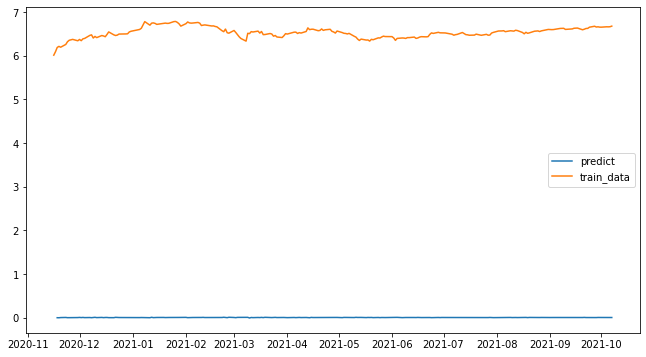

In [586]:
fitted_m2 = fitted_m.predict()
fitted_m2 = fitted_m2.drop(fitted_m2.index[0])
plt.plot(fitted_m2, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()
print(type(fitted_m))

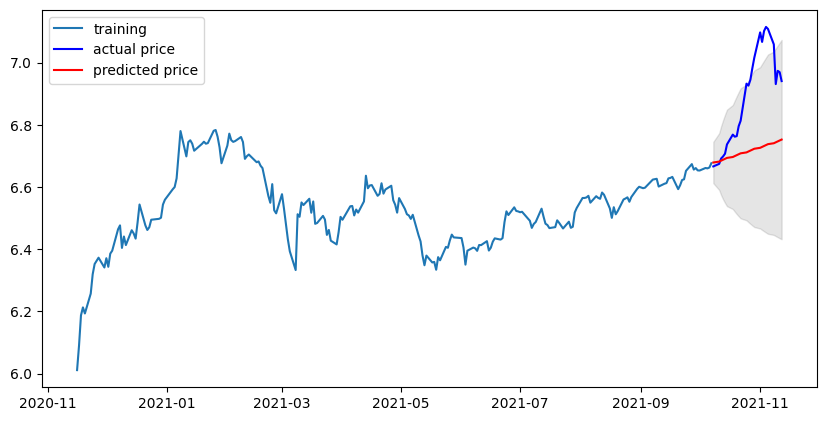

In [587]:
# Forecast : 데이터 구간의 데이터 예측
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [588]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  47345.32376386319
MAE:  172.98205619080878
RMSE:  217.58980620392856
MAPE: 15.74%


#### (3) p = 1, d =2, q = 0

In [589]:
# Build Model
model = ARIMA(train_data, order=(1, 2, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                  223
Model:                 ARIMA(1, 2, 0)   Log Likelihood                 390.919
Method:                       css-mle   S.D. of innovations              0.042
Date:                Mon, 15 Nov 2021   AIC                           -775.839
Time:                        17:22:45   BIC                           -765.617
Sample:                             2   HQIC                          -771.712
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0003      0.002     -0.183      0.855      -0.004       0.003
ar.L1.D2.Close    -0.5240      0.057     -9.233      0.000      -0.635      -0.413
                                    

<class 'statsmodels.tsa.arima_model.ARIMAResultsWrapper'>


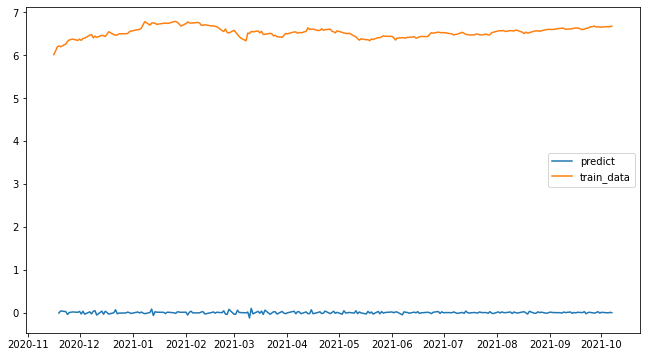

In [590]:
fitted_m2 = fitted_m.predict()
fitted_m2 = fitted_m2.drop(fitted_m2.index[0])
plt.plot(fitted_m2, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()
print(type(fitted_m))

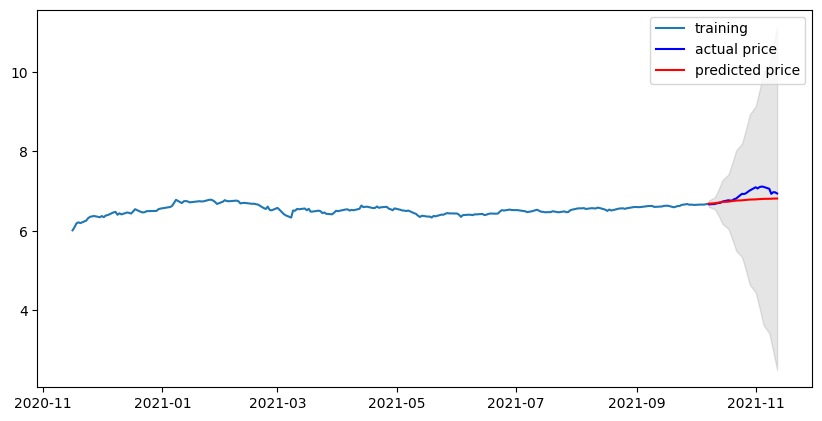

In [591]:
# Forecast : 데이터 구간의 데이터 예측
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [592]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  30876.786536345047
MAE:  133.42574678630623
RMSE:  175.71791751652717
MAPE: 12.00%


#### (4) p = 0, d =2, q = 0

In [593]:
# Build Model
model = ARIMA(train_data, order=(0, 2, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                  223
Model:                 ARIMA(0, 2, 0)   Log Likelihood                 354.948
Method:                           css   S.D. of innovations              0.049
Date:                Mon, 15 Nov 2021   AIC                           -705.896
Time:                        17:23:03   BIC                           -699.081
Sample:                             2   HQIC                          -703.145
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.003     -0.089      0.929      -0.007       0.006


<class 'statsmodels.tsa.arima_model.ARIMAResultsWrapper'>


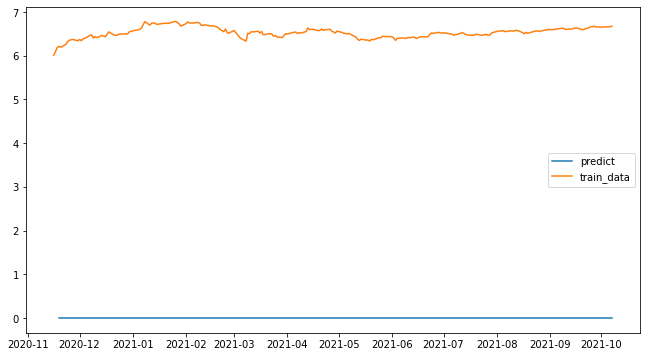

In [594]:
fitted_m2 = fitted_m.predict()
fitted_m2 = fitted_m2.drop(fitted_m2.index[0])
plt.plot(fitted_m2, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()
print(type(fitted_m))

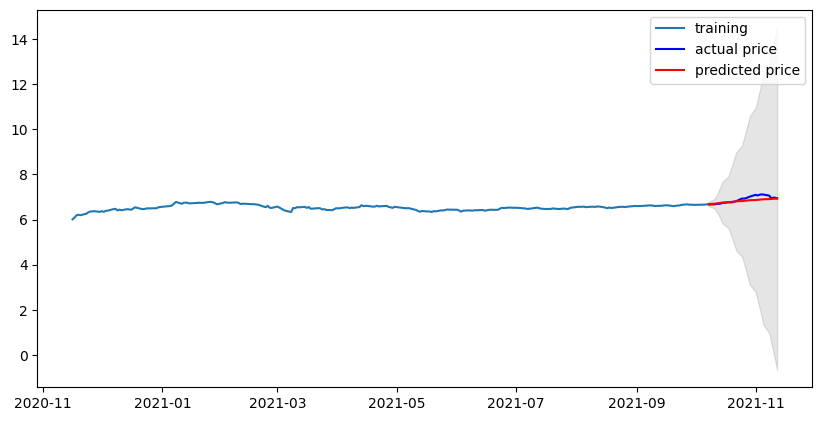

In [595]:
# Forecast : 데이터 구간의 데이터 예측
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [596]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  14929.415971092852
MAE:  86.20254660051909
RMSE:  122.18598925855964
MAPE: 7.73%


## 3. CSCO

### STEP 1: 시계열 데이터 준비

In [602]:
dataset_filepath = '/content/drive/MyDrive/AIffel/ex14/CSCO.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)

-----

### STEP 2: 데이터 전처리
- 결측치 확인

- 로그 변환

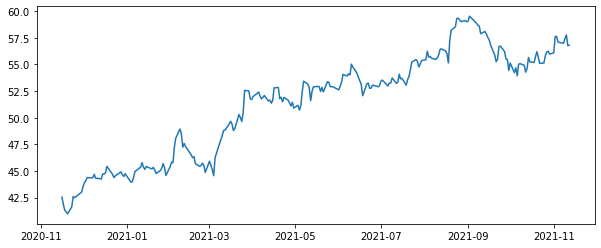

In [603]:
ts = df['Close']

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 4
plt.plot(ts)

Series([], Name: Close, dtype: float64)


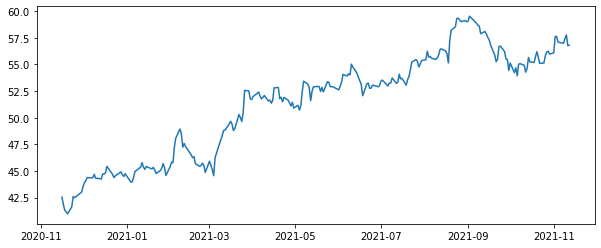

In [604]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

# 결측치가 있다면 이를 보간 
ts=ts.interpolate(method='time')

print(ts[ts.isna()])
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(ts)

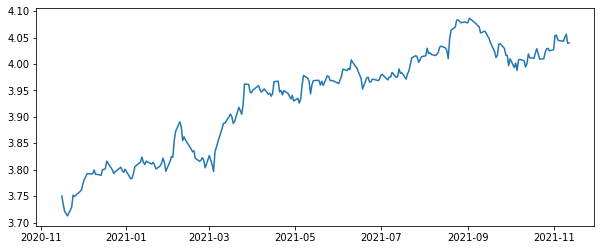

In [605]:
# 로그 변환 시도 
ts_log = np.log(ts)
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(ts_log)

-----

### STEP 3: 시계열 안정성 분석
- 정성적 그래프 분석

- 정량적 Augmented Dicky-Fuller Test

- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

- 20일(1개월), 60일(3개월), 120일(6개월) 주기로 그래프를 확인해본다.

- 초기 p-value는 약  0.37이며, 좀 더 자세히 분석해 보았다.

- Residual 안정성을 보면 p-value가 거의 0에 가까운 값인 것을 확인할 수 있다.

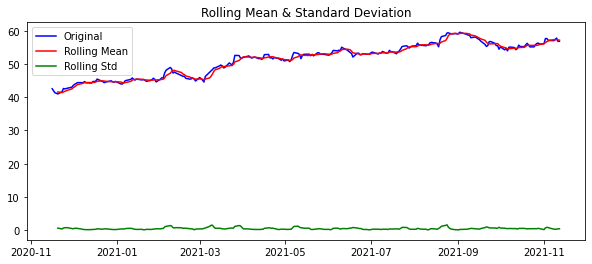

In [606]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_rolling_statistics(ts, window = 5)

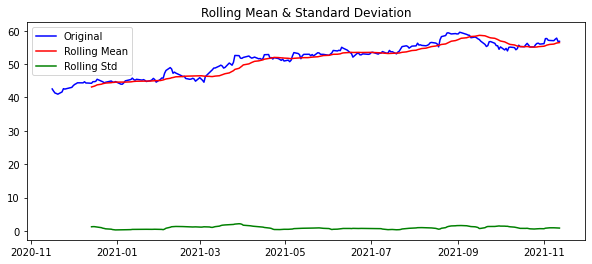

In [607]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_rolling_statistics(ts, window = 20)

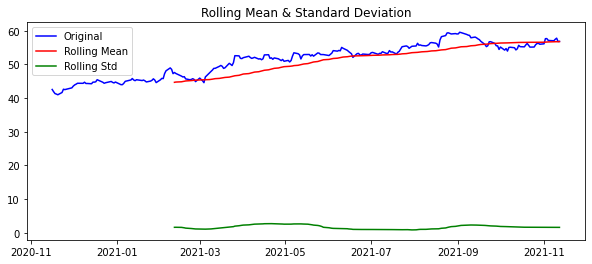

In [608]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_rolling_statistics(ts, window = 60)

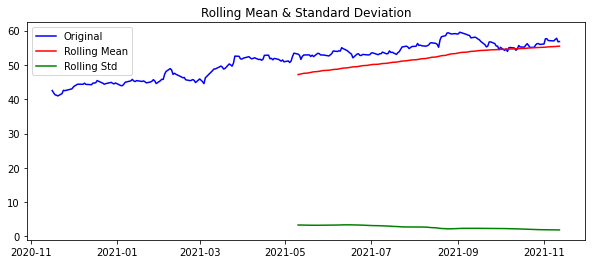

In [609]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_rolling_statistics(ts, window = 120)

In [610]:
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -1.807072
p-value                          0.376956
#Lags Used                       3.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


#### (1) 로그 함수 변환

In [611]:
ts_log = np.log(ts)

In [612]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.950953
p-value                          0.308484
#Lags Used                       2.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


#### (2) Moving average 제거 - 추세(Trend) 상쇄하기

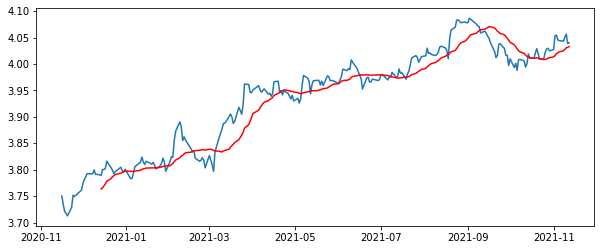

In [613]:
moving_avg20= ts_log.rolling(window=20).mean()  # moving average구하기 
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(ts_log)
plt.plot(moving_avg20, color='red')

In [614]:
ts_log_moving_avg20 = ts_log - moving_avg20 # 변화량 제거
ts_log_moving_avg20.dropna(inplace=True) # 결측치 제거
ts_log_moving_avg20.head(15)

Date
2020-12-14    0.025858
2020-12-15    0.034150
2020-12-16    0.030870
2020-12-17    0.029038
2020-12-18    0.037842
2020-12-21    0.020884
2020-12-22    0.013107
2020-12-23    0.004111
2020-12-24    0.005366
2020-12-28    0.011327
2020-12-29    0.003226
2020-12-30   -0.001433
2020-12-31    0.003649
2021-01-04   -0.013992
2021-01-05   -0.013085
Name: Close, dtype: float64

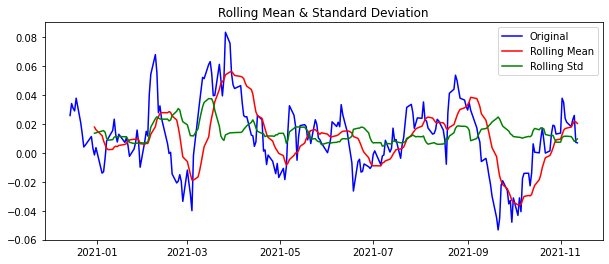

In [615]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_rolling_statistics(ts_log_moving_avg20)

In [616]:
augmented_dickey_fuller_test(ts_log_moving_avg20)

Results of Dickey-Fuller Test:
Test Statistic                  -3.706225
p-value                          0.004026
#Lags Used                       4.000000
Number of Observations Used    227.000000
Critical Value (1%)             -3.459490
Critical Value (5%)             -2.874358
Critical Value (10%)            -2.573602
dtype: float64


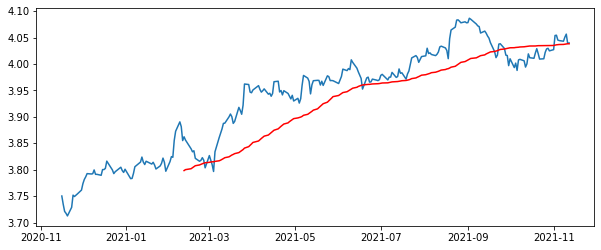

In [617]:
moving_avg60= ts_log.rolling(window=60).mean()  # moving average구하기 
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(ts_log)
plt.plot(moving_avg60, color='red')

In [618]:
ts_log_moving_avg60 = ts_log - moving_avg60 # 변화량 제거
ts_log_moving_avg60.dropna(inplace=True) # 결측치 제거
ts_log_moving_avg60.head(15)

Date
2021-02-11    0.063868
2021-02-12    0.055991
2021-02-16    0.037611
2021-02-17    0.030127
2021-02-18    0.030099
2021-02-19    0.013941
2021-02-22    0.007001
2021-02-23    0.007663
2021-02-24    0.011480
2021-02-25    0.005592
2021-02-26   -0.009492
2021-03-01    0.012752
2021-03-02    0.003396
2021-03-03   -0.005590
2021-03-04   -0.018368
Name: Close, dtype: float64

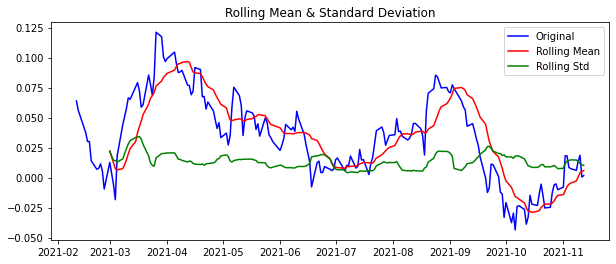

In [619]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_rolling_statistics(ts_log_moving_avg60)

In [620]:
augmented_dickey_fuller_test(ts_log_moving_avg60)

Results of Dickey-Fuller Test:
Test Statistic                  -1.967456
p-value                          0.301022
#Lags Used                       4.000000
Number of Observations Used    187.000000
Critical Value (1%)             -3.465812
Critical Value (5%)             -2.877123
Critical Value (10%)            -2.575077
dtype: float64


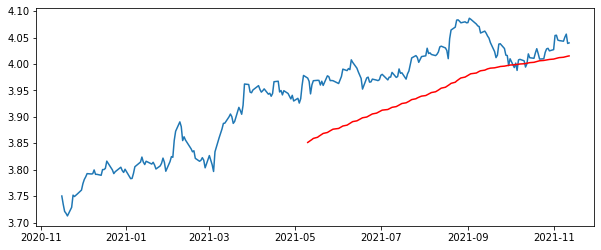

In [621]:
moving_avg120= ts_log.rolling(window=120).mean()  # moving average구하기 
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(ts_log)
plt.plot(moving_avg120, color='red')

In [622]:
ts_log_moving_avg120 = ts_log - moving_avg120 # 변화량 제거
ts_log_moving_avg120.dropna(inplace=True) # 결측치 제거
ts_log_moving_avg120.head(15)

Date
2021-05-10    0.121594
2021-05-11    0.113562
2021-05-12    0.088265
2021-05-13    0.103372
2021-05-14    0.109064
2021-05-17    0.107684
2021-05-18    0.105496
2021-05-19    0.095032
2021-05-20    0.100432
2021-05-21    0.090743
2021-05-24    0.107087
2021-05-25    0.103901
2021-05-26    0.094812
2021-05-27    0.093483
2021-05-28    0.091642
Name: Close, dtype: float64

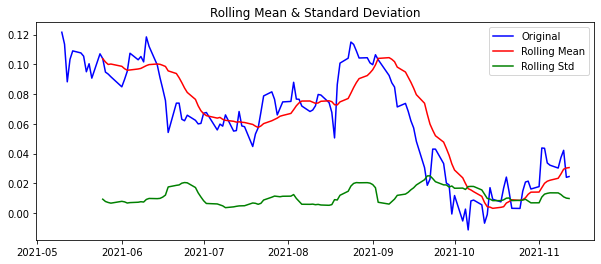

In [623]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_rolling_statistics(ts_log_moving_avg120)

In [624]:
augmented_dickey_fuller_test(ts_log_moving_avg120)

Results of Dickey-Fuller Test:
Test Statistic                  -1.909696
p-value                          0.327514
#Lags Used                       0.000000
Number of Observations Used    131.000000
Critical Value (1%)             -3.481282
Critical Value (5%)             -2.883868
Critical Value (10%)            -2.578677
dtype: float64


#### (3) 차분(Differencing) - 계절성(Seasonality) 상쇄하기

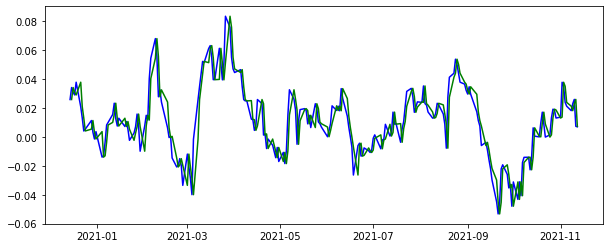

In [625]:
ts_log_moving_avg_shift = ts_log_moving_avg20.shift()
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(ts_log_moving_avg20, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

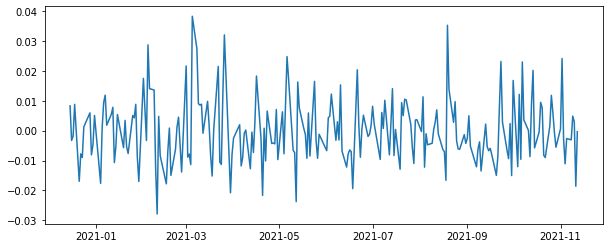

In [626]:
ts_log_moving_avg_diff = ts_log_moving_avg20 - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

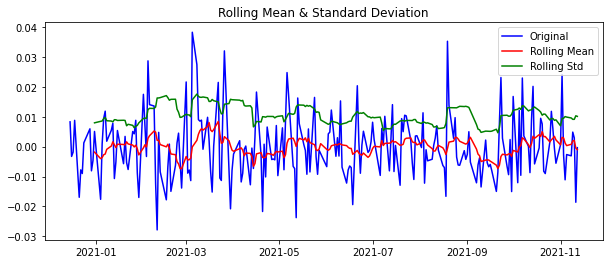

In [627]:
plot_rolling_statistics(ts_log_moving_avg_diff)

In [628]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                -1.169311e+01
p-value                        1.634798e-21
#Lags Used                     1.000000e+00
Number of Observations Used    2.290000e+02
Critical Value (1%)           -3.459233e+00
Critical Value (5%)           -2.874245e+00
Critical Value (10%)          -2.573541e+00
dtype: float64


#### (4) 시계열 분해(Time series decomposition)

In [629]:
ts_log

Date
2020-11-16    3.750445
2020-11-17    3.734808
2020-11-18    3.721347
2020-11-19    3.717710
2020-11-20    3.712840
                ...   
2021-11-08    4.043051
2021-11-09    4.050741
2021-11-10    4.056470
2021-11-11    4.038832
2021-11-12    4.039888
Name: Close, Length: 251, dtype: float64

In [630]:
type(ts_log.index)

pandas.core.indexes.datetimes.DatetimeIndex

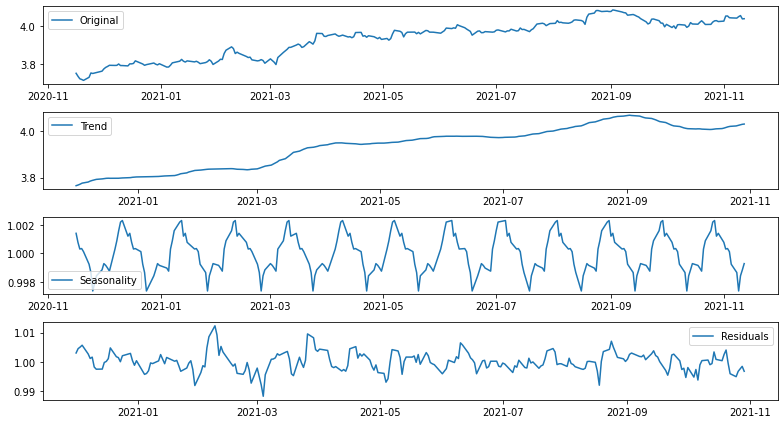

In [631]:
decomposition = seasonal_decompose(ts_log, model = 'multiplicative', freq = 20)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화)
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [632]:
residual.isna().sum()

20

In [633]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.124962
p-value                          0.000012
#Lags Used                      15.000000
Number of Observations Used    215.000000
Critical Value (1%)             -3.461136
Critical Value (5%)             -2.875079
Critical Value (10%)            -2.573986
dtype: float64


---
### STEP 4 : 학습, 테스트 데이터셋 생성
- 데이터를 9:1 비율로 나눠 train, test data를 생성한다.
- train data는 225, test data는 26인 것을 확인할 수 있다.

In [634]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

In [635]:
print(len(train_data))
print(len(test_data))

225
26


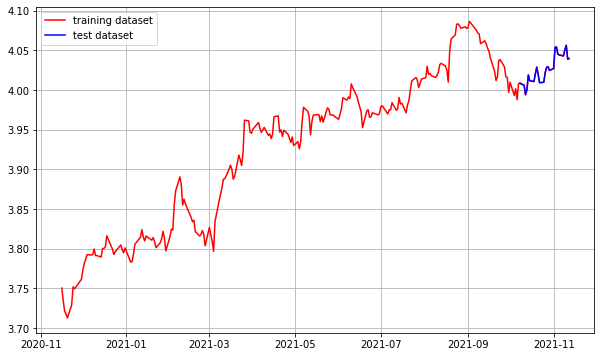

In [636]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

---
### STEP 5 : 적정 ARIMA 모수 찾기
- ACF, PACF 그려보기 -> p,q 구하기

- 차분 안정성 확인 -> d 구하기

- ACF 와 PACF 그래프를 확인해본다.

    - ACF: 그래프를 확인해보면 점차적으로 감소하는 형세를 볼 수 있다.
    - PACF: 그래프를 확인해보면 1 이후에 급격히 감소하는 것을 확인할 수 있다.
    - PACF 그래프를 통해 p = 1를 적용해보는 것을 고려할 수 있다.

- 차분을 구해보니 d = 2가 적절할 것 같다.

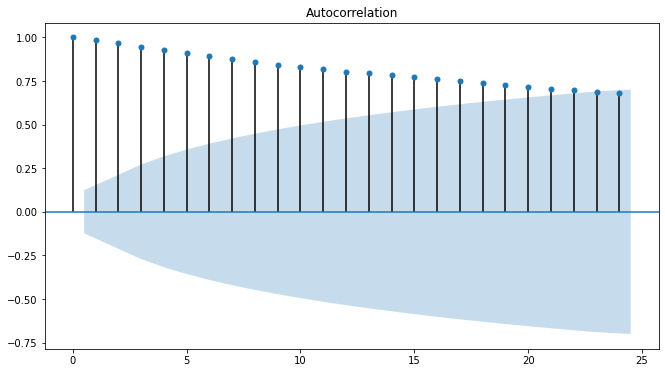

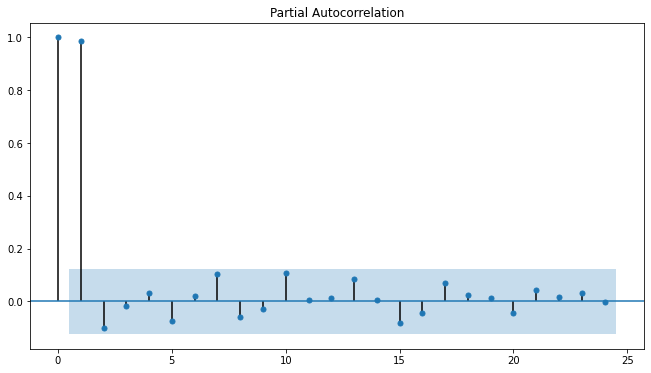

In [637]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.240347e+01
p-value                        4.506468e-23
#Lags Used                     1.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


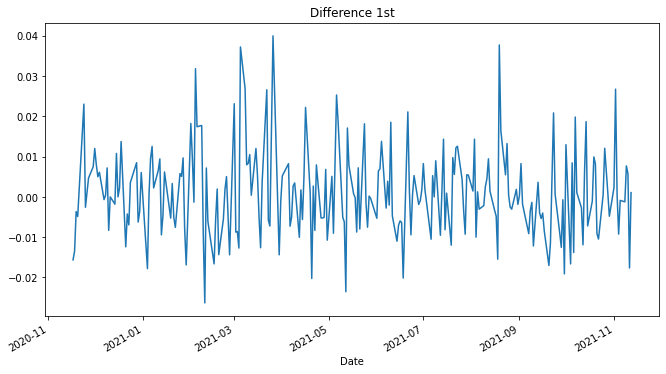

In [638]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -8.105471e+00
p-value                        1.266334e-12
#Lags Used                     1.300000e+01
Number of Observations Used    2.350000e+02
Critical Value (1%)           -3.458487e+00
Critical Value (5%)           -2.873919e+00
Critical Value (10%)          -2.573367e+00
dtype: float64


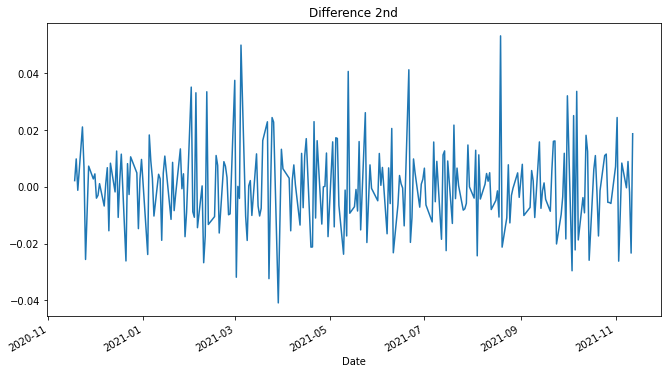

In [639]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

----
### STEP 6 : ARIMA 모델 훈련과 테스트

- ARIMA 모델 빌드와 훈련

- 모델 테스트 및 플로팅

- 최종 예측 모델 정확도 측정(MAPE)

#### p = 1, d =1, q = 0

In [640]:
# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 692.574
Method:                       css-mle   S.D. of innovations              0.011
Date:                Mon, 15 Nov 2021   AIC                          -1379.148
Time:                        17:26:42   BIC                          -1368.913
Sample:                             1   HQIC                         -1375.017
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0011      0.001      1.458      0.146      -0.000       0.003
ar.L1.D.Close     0.0687      0.067      1.021      0.309      -0.063       0.201
                                    Root

<class 'statsmodels.tsa.arima_model.ARIMAResultsWrapper'>


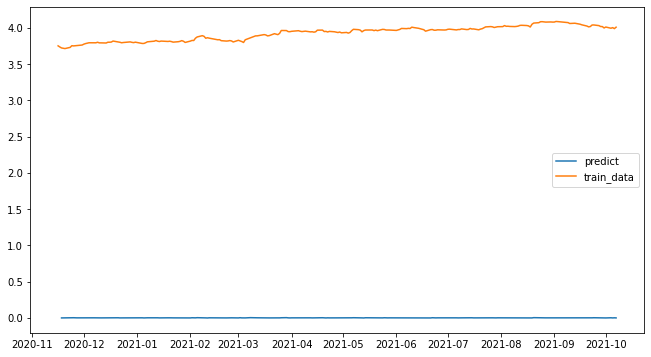

In [641]:
fitted_m2 = fitted_m.predict()
fitted_m2 = fitted_m2.drop(fitted_m2.index[0])
plt.plot(fitted_m2, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()
print(type(fitted_m))

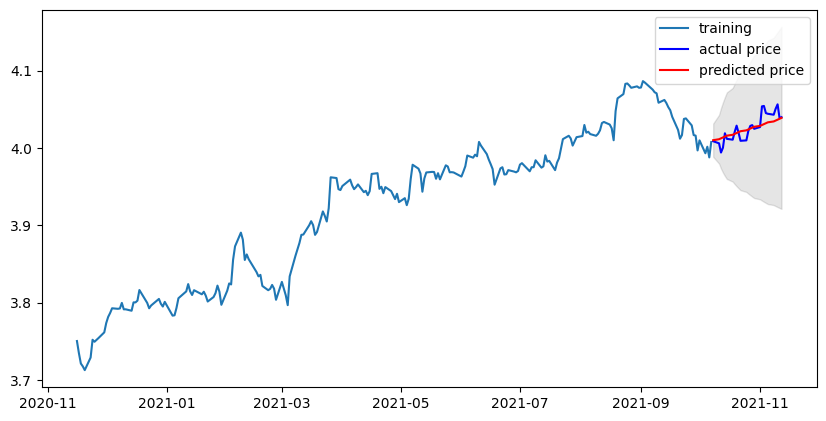

In [642]:
# Forecast : 데이터 구간의 데이터 예측
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [643]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  0.39172066139500133
MAE:  0.4787077007297164
RMSE:  0.6258759153338634
MAPE: 0.85%


---
# 결과 및 회고 

## 루브릭

| 평가문항 | 상세기준 | 
| :--- | :--- | 
|1. 시계열의 안정성이 충분히 확인되었는가?|플로팅과 aadfuuller 메소드가 모두 적절히 사용되었음|
|2. ARIMA 모델 모수 선택 근거를 체계적으로 제시하였는가?|p, q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨|
|3. 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가?| 3개 이상 종목이 MAPE 15% 미만의 정확도로 예측됨|



## 결과

**1. 삼성전자**  
삼성전자의 경우 모수 설정을 `p =1, d=2, q=0`으로 했을 때 MAPE가 `1.37%`로 가장 낮았다.  
(MAPE 15% 미만 성공)

| No. | p, d, q | MAPE |
| :---: | :---: | :---:|
| 1 | p = 1, d = 0, q = 0 | 2.65 % |
| 2 | p = 1, d = 1, q = 0 | 2.39 % |
| 3 | p = 1, d = 2, q = 0 | 1.37 % |
| 4 | p = 0, d = 1, q = 1 | 2.41 % |

**2. AAPL**   
AAPL의 경우 모수 설정을 `p =1, d=1, q=0`, `p =0, d=1, q=1`으로 했을 때 MAPE가 `2.49%`로 가장 낮았다. 
(MAPE 15% 미만 성공) 

| No. | p, d, q | MAPE |
| :---: | :---: | :---:|
| 1 | p = 1, d = 0, q = 0 | 5.05 % |
| 2 | p = 1, d = 1, q = 0 | 2.49 % |
| 3 | p = 1, d = 2, q = 0 | 9.26 % |
| 4 | p = 0, d = 1, q = 1 | 2.49 % |

**3. TSLA**  
TSLA의 경우 모수 설정을 `p =0, d=2, q=0`으로 했을 때 MAPE가 `7.73%`로 가장 낮았다.  
(MAPE 15% 미만 성공)

| No. | p, d, q | MAPE |
| :---: | :---: | :---:|
| 1 | p = 1, d = 0, q = 0 | 21.15 % |
| 2 | p = 1, d = 1, q = 0 | 15.74 % |
| 3 | p = 1, d = 2, q = 0 | 12.00 % |
| 4 | p = 0, d = 2, q = 0 | 7.73 % |

**4. CSCO**  
(MAPE 15% 미만 성공)
CSCO의 경우 모수 설정을 `p =1, d=1, q=0`으로 했을 때 MAPE가 `0.85%`로 매우 낮은 수치를 보였다.  

| No. | p, d, q | MAPE |
| :---: | :---: | :---:|
| 1 | p = 1, d = 1, q = 0 | 0.85 % |



## 회고
주식을 다루다보니 흥미로웠던 프로젝트였다.  
이번 프로젝트에서는 시계열 안정성 분석과 모수 찾기가 어려웠던 것 같다.  
특히 모수 찾는 건.. 정말 아리송하다.  
감을 잡을 것 같으면서도 잘 모르겠다.  
노드를 다시 정독하며 공부해봐야할 것 같고 관련 자료도 좀 더 찾아봐야할 것 같다.  
이번 프로젝트를 하는 과정도 매우 유익했던 시간이었지만 아직 많이 부족함을 느낀다.  
더 공부하러 가야겠다... 